### Analisys of delivery order data

The goal of this analysis is to understand patterns in delivery orders, evaluate operational performance and identify factors influencing delivery success. The dataset contains processed delivery-level information, including timestamps, order status, distances, regions.

The analysis focuses on:

- Order correctness and reasons for delivery failure

- Time-based patterns in orders

- Geographic patterns

- Courier-related behaviors

- Feature engineering for deeper insights

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

Firstly we read the cleaned dataset from csv file.

In [2]:
data=pd.read_csv("../data/processed/final_data.csv")

Before the analysis, we add new columns to enable deeper insights:

- Is Order Ready Correctly: A binary flag indicating whether an order was marked ready correctly. This is a direct measure of kitchen process reliability.

- Order Preparation Time: The total time from receiving the order to it being ready for the rider (KPT duration + Rider wait time). This is a crucial Key Performance Indicator (KPI) for operational efficiency.

- Items count and Items per Order Category: We parsed the order text to count the number of items and categorized orders into:

Single meal: 1 item

Small group: 2-3 items

Family order: 4-6 items

Catering size: 7+ items

This helps in understanding order complexity and customer type.

In [3]:
data['Is Order Ready Correctly']=data['Order Ready Marked']=='Correctly'

In [4]:
data['Order Preparation Time']=data['KPT duration (minutes)']+data['Rider wait time (minutes)']

In [5]:
def count_items(order_text):
    if pd.isna(order_text) or not isinstance(order_text, str):
        return 0
    matches=re.findall(r'\b\d+\s*x\b', order_text)
    return len(matches)

data['Items count']=data['Items in order'].apply(count_items)

def categorize_items(x):
    if x==1:
        return 'Single meal'
    elif 2<=x<=3:
        return 'Small group'
    elif 4<=x<=6:
        return 'Family order'
    else:
        return 'Catering size'

data['Items per Order Category']=data['Items count'].apply(categorize_items)

In [91]:
def extract_dishes(order_text):
    if pd.isna(order_text) or not isinstance(order_text, str):
        return []

    dish_pattern=r'\d+\s*x\s*([^,]+)'
    dishes=re.findall(dish_pattern, order_text)
    cleaned_dishes=[dish.strip().lower() for dish in dishes]
    return cleaned_dishes

if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    for restaurant in restaurants:
        restaurant_data=data[data['Restaurant name']==restaurant]
        
        all_dishes=[]
        for order in restaurant_data['Items in order']:
            dishes_in_order=extract_dishes(order)
            all_dishes.extend(dishes_in_order)
            
        dish_popularity=Counter(all_dishes)
        popular_dishes_data=pd.DataFrame(dish_popularity.items(), columns=['Dish', 'Frequency']).sort_values('Frequency', ascending=False)
        
        print("Most popular dishes in", restaurant)
        print(f"Total unique dishes: {len(popular_dishes_data)}")
        print(popular_dishes_data.head(10))
        print("\n")


Most popular dishes in Swaad
Total unique dishes: 94
                                 Dish  Frequency
10   bone in jamaican grilled chicken       1640
13  bone in smoky bbq grilled chicken        742
19                       animal fries        737
5   bone in peri peri grilled chicken        591
0     grilled chicken jamaican tender        586
14     fried chicken peri peri tender        563
21     bone in kabuli grilled chicken        494
11     bone in angara grilled chicken        446
17   grilled chicken smoky bbq tender        390
29       fried chicken classic tender        385


Most popular dishes in Aura Pizzas
Total unique dishes: 76
                           Dish  Frequency
2                bageecha pizza       3119
0    chilli cheese garlic bread       1750
4       all about chicken pizza       1632
15         makhani paneer pizza       1453
13             margherita pizza       1342
3           cheesy garlic bread       1155
11        jamaican chicken melt       1148
14 

We can see here top 10 dishes in every restaurant. The data shows clear differences in customer preferences across the six restaurants. Swaad is strongly focused on grilled chicken varieties. Jamaican on smoky bbq and peri peri cuts dominating its top sellers. Aura Pizzas highlights a classic pizza-driven menu, where bageecha pizza, chilli cheese garlic bread and several chicken or paneer pizzas lead by a large margin. Dilli Burger Adda reflects a burger centric profile with mutton and chicken smashed burgers, bacon melt burgers and loaded fries among the most popular items. Tandoori Junction is centered around boneless grilled chicken in various spice profiles, supported by a few sides such as fries and vegetables. The Chicken Junction shows a concise fried chicken menu with tangdi, boneless bites and fries as the main volume drivers. Masala Junction has the smallest menu, led primarily by fries and a few paneer or chicken sliders.

**Overall, the data appears consistent with each concept showing a distinct menu structure and a clear pattern of top performing dishes aligned with its culinary theme.**

In [77]:
if 'Restaurant name' in data.columns:
    for restaurant in data['Restaurant name'].unique():
        print(f"RESTAURANT: {restaurant}")
 
        restaurant_data=data[data['Restaurant name']==restaurant]
        
        category_popularity=restaurant_data.groupby('Items per Order Category').apply(
            lambda x: Counter([dish for order in x['Items in order'] for dish in extract_dishes(order)]),
            include_groups=False
        )

        print("Popular dishes by order category:")
        for category, counter in category_popularity.items():
            top_dish=counter.most_common(1)[0] if counter else ("None", 0)
            print(f"{category}: {top_dish[0]} (ordered {top_dish[1]} times)")
        print("\n")


RESTAURANT: Swaad
Popular dishes by order category:
Catering size: bone in jamaican grilled chicken (ordered 10 times)
Family order: bone in jamaican grilled chicken (ordered 105 times)
Single meal: bone in jamaican grilled chicken (ordered 700 times)
Small group: bone in jamaican grilled chicken (ordered 825 times)


RESTAURANT: Aura Pizzas
Popular dishes by order category:
Catering size: bageecha pizza (ordered 17 times)
Family order: bageecha pizza (ordered 324 times)
Single meal: bageecha pizza (ordered 956 times)
Small group: bageecha pizza (ordered 1822 times)


RESTAURANT: Dilli Burger Adda
Popular dishes by order category:
Family order: peri peri fries (ordered 3 times)
Single meal: dirty saucy fries (ordered 23 times)
Small group: mutton smashed burger (ordered 37 times)


RESTAURANT: Tandoori Junction
Popular dishes by order category:
Family order: peri peri boneless grilled chicken breast (ordered 3 times)
Single meal: chicken 65 boneless grilled chicken breast (ordered 20 t

Swaad: dominates across all categories with bone-in jamaican grilled chicken, especially popular in small group (825 orders) and single meal (700 orders) segments.

Aura Pizzas: bageecha pizza leads consistently, with highest demand in small group (1,822 orders) and single meal (956 orders) orders.

Dilli Burger Adda: most popular items vary by category: mutton smashed burger (small group, 37 orders), dirty saucy fries (single meal, 23 orders), and peri peri fries (family order, 3 orders).

Tandoori Junction: grilled chicken variants are most ordered, with chicken 65 boneless topping single meal (20 orders) and angara boneless for small group (13 orders).

The Chicken Junction: fried chicken tangdi 2pcs is favored in family (3 orders) and single meal (6 orders), while dynamite sauce is popular in small group (5 orders).

Masala Junction: ooh saucy fries lead single meal orders (9 orders), with fried paneer angara slider trending in small group (2 orders).

**Swaad and Aura Pizzas show high volume and category dominance. Other restaurants show more varied preferences with lower order counts. Single meals and small group orders consistently generate the highest demand across most outlets.**

In [86]:
print("The most common combinations:")

def dish_combinations(order):
    dishes=extract_dishes(order)
    return tuple(sorted(dishes)) if len(dishes)>1 else None

if 'Restaurant name' in data.columns:
    for restaurant in data['Restaurant name'].unique():
        print(f"RESTAURANT {restaurant}")
        restaurant_data=data[data['Restaurant name']==restaurant]
        combinations=restaurant_data['Items in order'].apply(dish_combinations).dropna()
        common_combinations=Counter(combinations).most_common(3)
        
        print("Top 3 dish combinations:")
        for i, (combo, count) in enumerate(common_combinations, 1):
            print(f"  {i}. {', '.join(combo)}: {count} orders")
        print("\n")


The most common combinations:
RESTAURANT Swaad
Top 3 dish combinations:
  1. bone in jamaican grilled chicken, bone in smoky bbq grilled chicken: 107 orders
  2. bone in jamaican grilled chicken, bone in peri peri grilled chicken: 101 orders
  3. bone in angara grilled chicken, bone in jamaican grilled chicken: 56 orders


RESTAURANT Aura Pizzas
Top 3 dish combinations:
  1. bageecha pizza, chilli cheese garlic bread: 213 orders
  2. bageecha pizza, makhani paneer pizza: 204 orders
  3. all about chicken pizza, bageecha pizza: 112 orders


RESTAURANT Dilli Burger Adda
Top 3 dish combinations:
  1. grilled chicken dirty burger, mutton smashed burger: 13 orders
  2. dirty saucy fries, mutton smashed burger: 10 orders
  3. dirty saucy fries, grilled chicken dirty burger: 6 orders


RESTAURANT Tandoori Junction
Top 3 dish combinations:
  1. angara boneless grilled chicken breast, peri peri fries: 2 orders
  2. chicken 65 boneless grilled chicken breast, grlld masala fries: 2 orders
  3. an

Swaad: Jamaican grilled chicken combos dominate (smoky bbq & peri peri), high repeat orders.

Aura Pizzas: Bageecha pizza paired with sides or other pizzas leads the charts.

Dilli Burger Adda: Fries and burgers combinations are most common, but overall counts are low.

Tandoori Junction: Grilled chicken combos appear, but orders are minimal.

The Chicken Junction and Masala Junction: Low frequency, varied combos with chicken or sliders.

**Swaad and Aura Pizzas show clear favorite combinations. Other restaurants show scattered preferences with low repeat orders.**

In [11]:
data.to_csv('../data/processed/final_data_extended.csv', index=False)

In [12]:
data.to_excel('../data/processed/final_data_extended.xlsx', index=False)

We saved the created data to the csv and xlsx file.

In [13]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

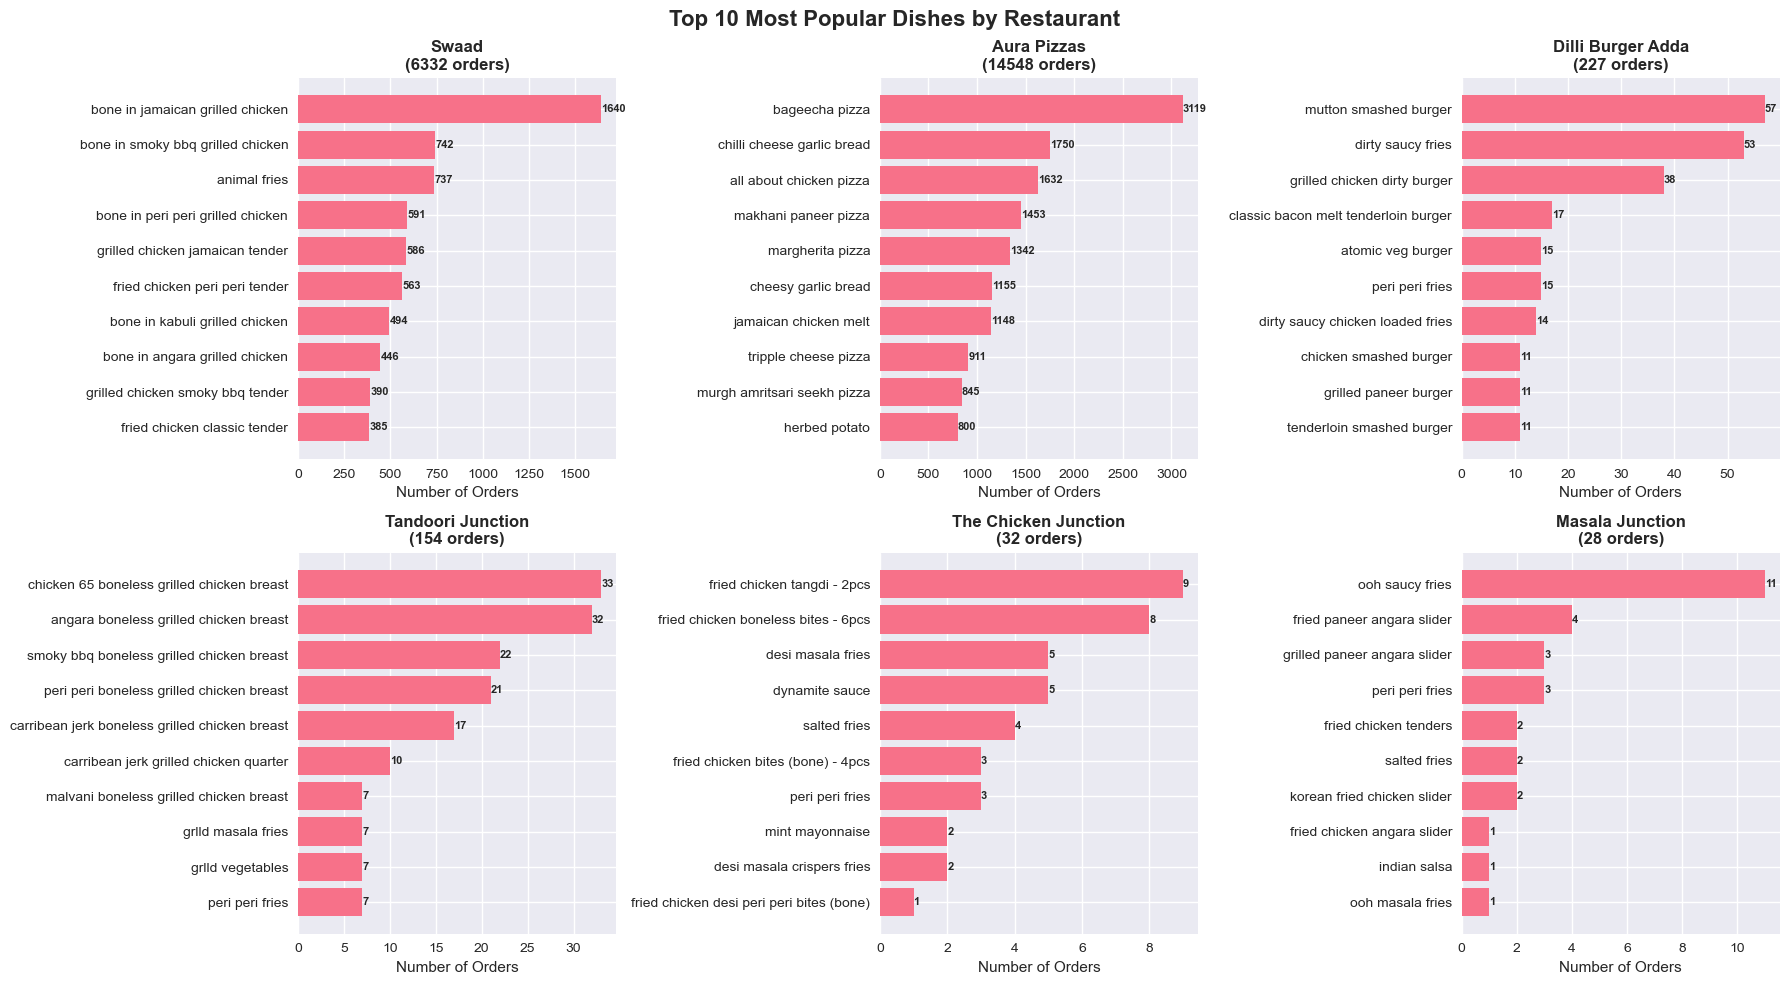

In [14]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18, 10))
    axes=axes.flatten()
    
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            data_res=data[data['Restaurant name']==restaurant]

            all_dishes_res=[]
            for order in data_res['Items in order']:
                dishes_in_order=extract_dishes(order)
                all_dishes_res.extend(dishes_in_order)
            
            dish_popularity_res=Counter(all_dishes_res)
            popular_dishes_res=pd.DataFrame(dish_popularity_res.items(), columns=['Dish', 'Frequency']).sort_values('Frequency', ascending=False).head(10)
            
            if not popular_dishes_res.empty:
                bars=axes[i].barh(popular_dishes_res['Dish'], popular_dishes_res['Frequency'])
                axes[i].set_xlabel('Number of Orders')
                axes[i].set_title(f'{restaurant}\n({len(data_res)} orders)', fontweight='bold')
                axes[i].invert_yaxis()
                for bar in bars:
                    width=bar.get_width()
                    axes[i].text(width, bar.get_y()+bar.get_height()/2, f'{int(width)}', ha='left', va='center', fontweight='bold', fontsize=8)    
    plt.suptitle('Top 10 Most Popular Dishes by Restaurant', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

The visualization shows the top 10 most frequently ordered dishes across six different restaurants. 
Each location has a distinct menu profile: Swaad focuses on grilled chicken, Aura Pizzas on pizzas, Dilli Burger Adda on burgers and fries and the others on fried items. This variation suggests that each restaurant has its own unique specialization and customer preference structure. Total order volumes vary widely across restaurants. Aura Pizzas and Swaad lead by a large margin, while smaller locations show lower but more evenly distributed dish counts. It might suggest that they are newer restaurants, have limited operating hours or niche customer groups. The customers tend to order from the restaurant’s signature category, which is a healthy sign of brand consistency. 

**Overall, the chart highlights clear differences in cuisine focus and customer preferences across restaurants.**

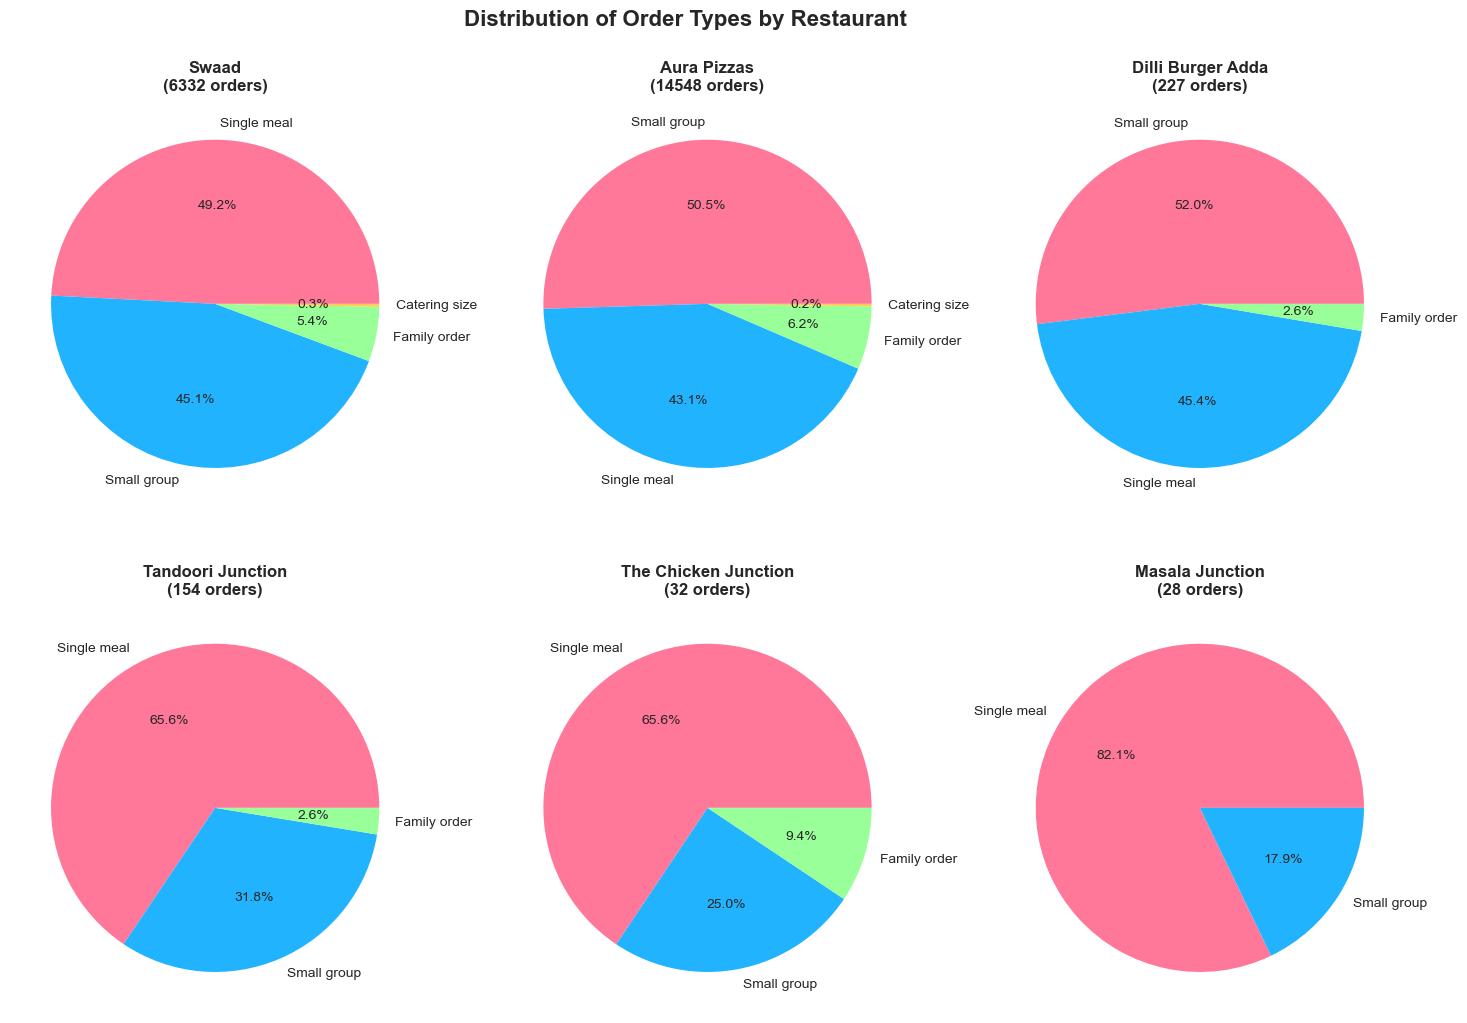

In [15]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18, 12))
    axes=axes.flatten()
    colors=['#ff7799', '#22b3ff', '#99ff99', '#ffcc55']
    
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            order_category_counts=restaurant_data['Items per Order Category'].value_counts()
            axes[i].pie(order_category_counts.values, labels=order_category_counts.index, autopct='%1.1f%%', colors=colors)
            axes[i].set_title(f'{restaurant}\n({len(restaurant_data)} orders)', fontweight='bold')
    
    plt.suptitle('Distribution of Order Types by Restaurant', fontsize=16, fontweight='bold', y=0.95)
    plt.show()

The figure displays six pie charts illustrating the distribution of order types (Single meal, Small group, Family order and Catering size) across 6 different restaurants. The total number of orders analyzed for each restaurant is indicated above each chart, which highlight differences in sample size.

**Observations**

- For nearly all restaurants single-meal orders are the most common category. Tandoori Junction and The Chicken Junction show the highest share of single-meal orders. Masala Junction has an even stronger skew, with 82% of its orders being single meals.

This suggests that these restaurants mainly serve individual customers rather than groups.

- Restaurants with large order volumes: Swaad, Aura Pizzas and Dilli Burger Adda, show a more balanced pattern Small-group orders account for 4-50% of orders in these restaurants.

This indicates they take care of not only individuals but also frequently small groups (2-4 people).

- Family-sized orders generally make up 5-10% of orders in the larger restaurants. Aura Pizzas (6.2%) and Swaad (5.4%) have the highest share. Smaller restaurants have fewer family orders, likely due to their lower customer throughput.

- Catering-sized orders represent less than 0.5% in high-volume restaurants and are almost nonexistent in others.

This suggests that large-event catering is not a major service category for these restaurants.

- Restaurants like Swaad and Aura Pizzas (6 000 - 14 000 orders) provide more reliable, representative distributions.
Masala Junction and The Chicken Junction (under 50 orders each) may show skewed proportions due to extremely small sample sizes.

**The visualization clearly indicates that single-meal and small-group orders make up the vast majority of demand across restaurants. Larger group or catering orders are rare. High-volume restaurants tend to have more balanced order patterns, while smaller restaurants are dominated by single-meal purchases.**

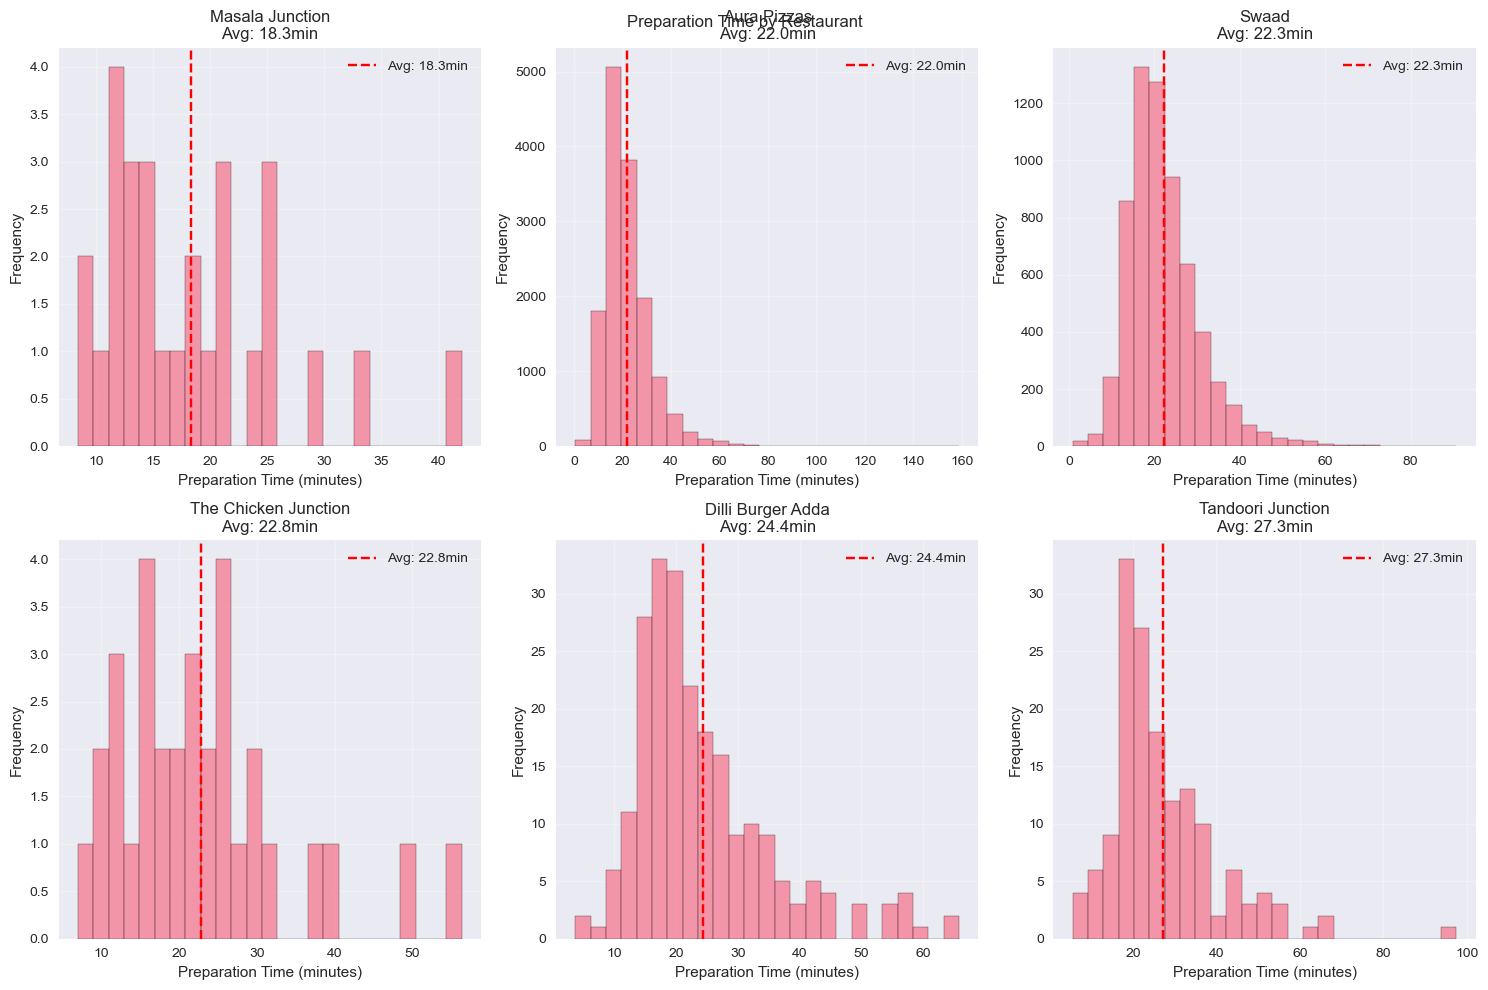

Restaurants sorted by average preparation time (fastest to slowest):
1. Masala Junction: 18.3 minutes
2. Aura Pizzas: 22.0 minutes
3. Swaad: 22.3 minutes
4. The Chicken Junction: 22.8 minutes
5. Dilli Burger Adda: 24.4 minutes
6. Tandoori Junction: 27.3 minutes


In [16]:
if 'Restaurant name' in data.columns:
    plt.figure(figsize=(15, 10))
    
    restaurant_avg_times=data.groupby('Restaurant name')['Order Preparation Time'].mean().sort_values()
    restaurants=restaurant_avg_times.index.tolist()
    
    for i, restaurant in enumerate(restaurants, 1):
        plt.subplot(2, 3, i)
        restaurant_data=data[data['Restaurant name']==restaurant]
        plt.hist(restaurant_data['Order Preparation Time'], bins=25, edgecolor='black', alpha=0.7)
        avg_time=restaurant_data['Order Preparation Time'].mean()
        plt.axvline(avg_time, color='red', linestyle='--', label=f'Avg: {avg_time:.1f}min')
        plt.xlabel('Preparation Time (minutes)')
        plt.ylabel('Frequency')
        plt.title(f'{restaurant}\nAvg: {avg_time:.1f}min')
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Preparation Time by Restaurant')
    plt.show()
    
    # Print the ranking
    print("Restaurants sorted by average preparation time (fastest to slowest):")
    for rank, (restaurant, avg_time) in enumerate(restaurant_avg_times.items(), 1):
        print(f"{rank}. {restaurant}: {avg_time:.1f} minutes")


The figure presents a comparative analysis of food preparation times across six restaurants, using individual histograms to illustrate the distribution and consistency of their service durations. Each subplot represents one restaurant and displays the frequency of preparation time alongside a vertical dashed red line indicating the mean value.
The average preparation time for each establishment is clearly labeled at the top of each histogram.

Across the restaurants we can see a notable differences in preparation-time behavior. Masala Junction demonstrates the lowest mean preparation time (18.3 minutes) with relatively low variability, suggesting efficient and consistent operations. Swaad also exhibits a stable distribution centered around 22.3 minutes. In contrast, Aura Pizzas and Tandoori Junction show significant variability and the presence of high-duration outliers, indicating operational inconsistency or occasional delays. Dilli Burger Adda and The Chicken Junction fall in the mid-range with averages around 22-24 minutes and moderate dispersion.

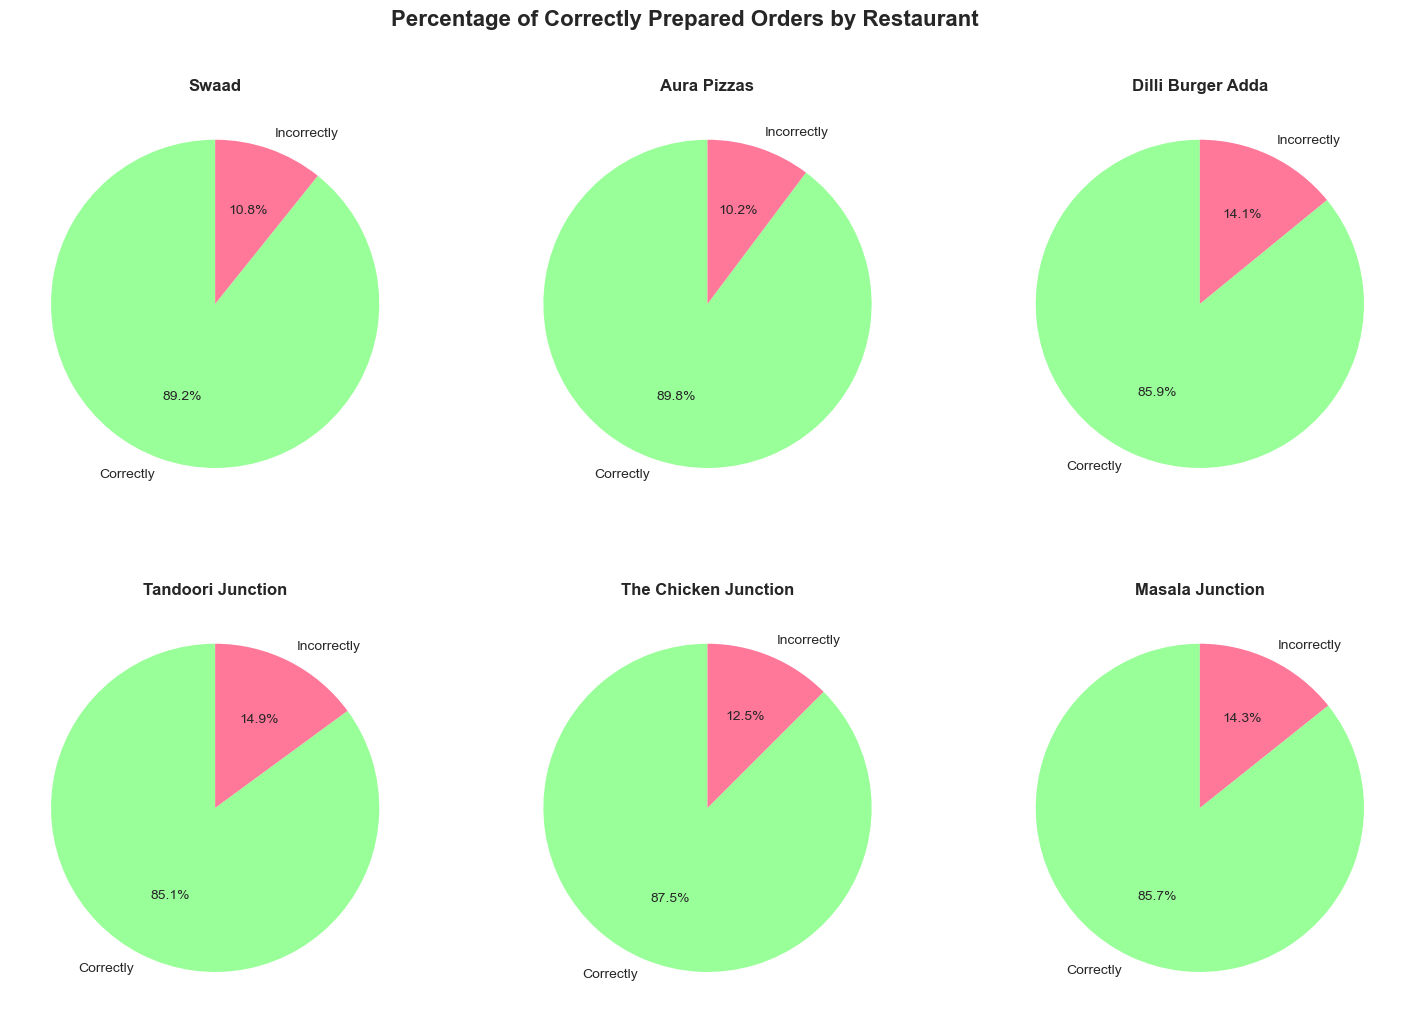

In [17]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18, 12))
    axes=axes.flatten()
    
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            correct_prep=restaurant_data['Is Order Ready Correctly'].value_counts()

            axes[i].pie(correct_prep.values, labels=['Correctly', 'Incorrectly'], autopct='%1.1f%%', startangle=90, colors=['#99ff99', '#ff7799'])
            axes[i].set_title(f'{restaurant}', fontweight='bold')
    
    plt.suptitle('Percentage of Correctly Prepared Orders by Restaurant', fontsize=16, fontweight='bold', y=0.95)
    plt.show()


Above six pie charts are displayed with the percentage of correctly and incorrectly prepared orders for different restaurants. Each chart is divided into two segments:

- Light green represents orders prepared correctly.

- Pink represents orders prepared incorrectly.

**Overall all restaurants have relatively high accuracy with correct order percentages mostly between 85% and 90%.**

Average preparation time of Swaad: 27 minutes
Average preparation time of Aura Pizzas: 29 minutes
Average preparation time of Dilli Burger Adda: 27 minutes
Average preparation time of Tandoori Junction: 29 minutes
Average preparation time of The Chicken Junction: 27 minutes
Average preparation time of Masala Junction: 20 minutes


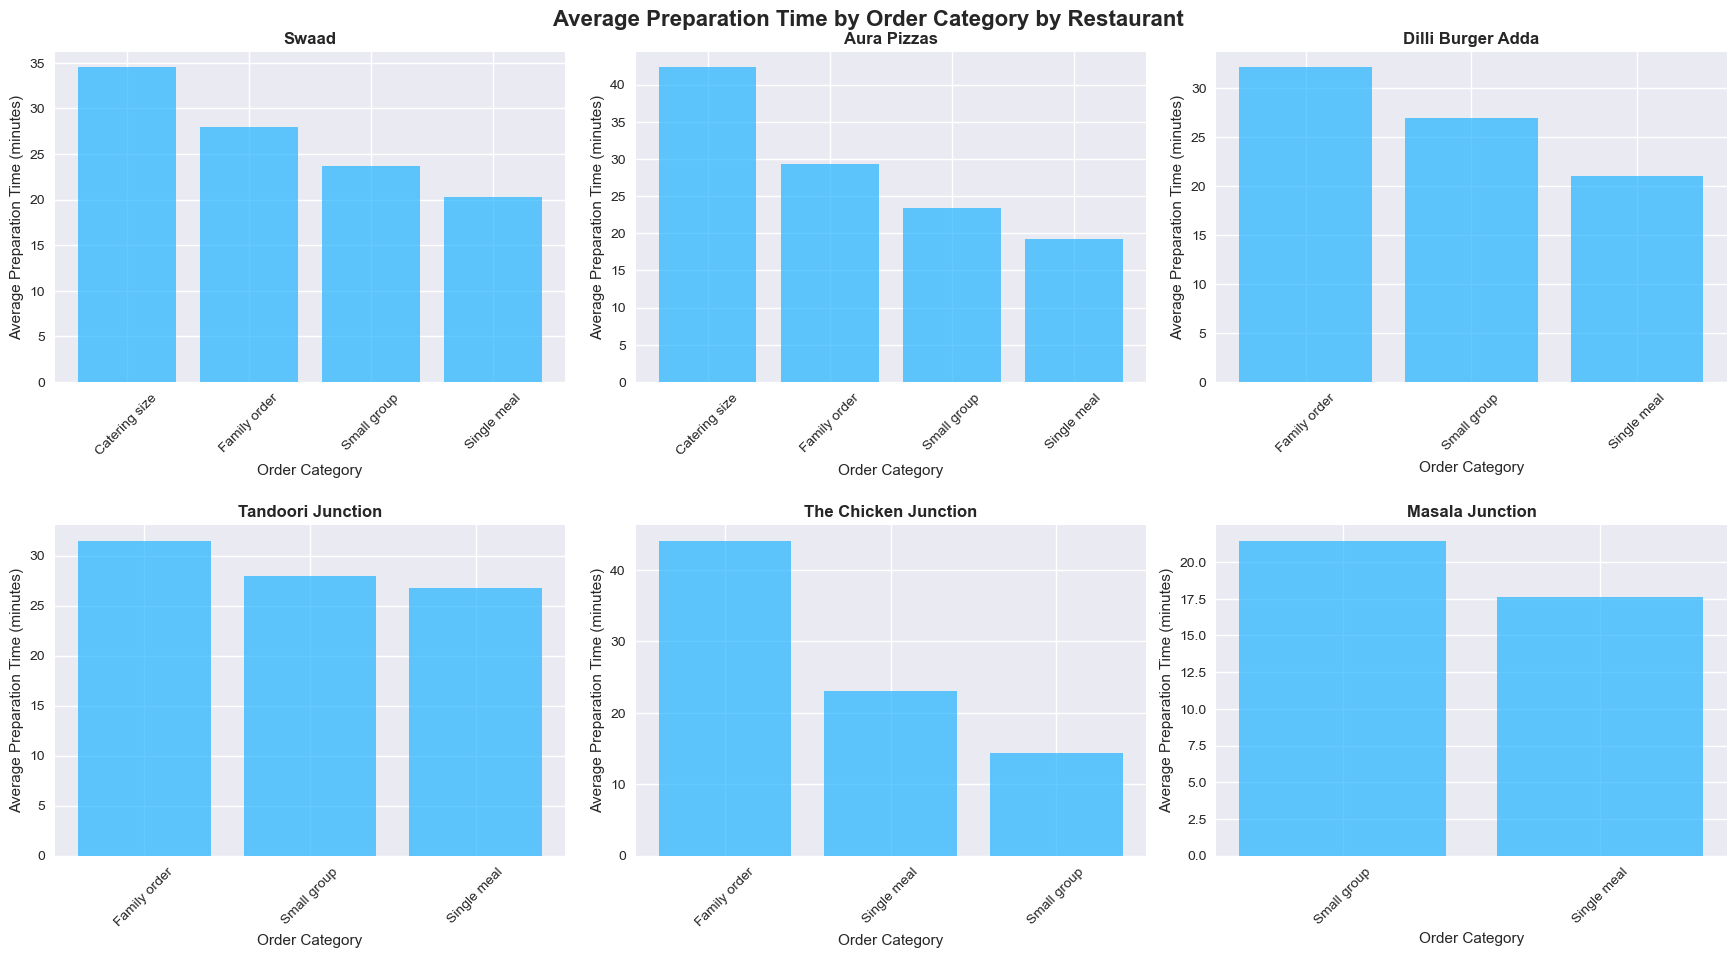

In [18]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18, 10))
    axes=axes.flatten()
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            time_by_category=restaurant_data.groupby('Items per Order Category')['Order Preparation Time'].mean()
            time_by_category=time_by_category.sort_values(ascending=False)
            bars=axes[i].bar(time_by_category.index, time_by_category.values, color='#22b3ff', alpha=0.7)
            axes[i].set_xlabel('Order Category')
            axes[i].set_ylabel('Average Preparation Time (minutes)')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].set_title(f'{restaurant}', fontweight='bold')
            print(f"Average preparation time of {restaurant}: {round(time_by_category.mean()):} minutes")
    plt.tight_layout(pad=3.0, h_pad=2.0, w_pad=1.0)
    plt.suptitle('Average Preparation Time by Order Category by Restaurant', fontsize=16, fontweight='bold')
    plt.show()


The diagrams show how average preparation time changes depending on the order category for every restaurant.

**Across all restaurants, larger orders take significantly longer to prepare, while single meals are fastest. Masala Junction is the quickest overall, while Aura Pizzas and Tandoori Junction tend to need the most time for larger orders.**

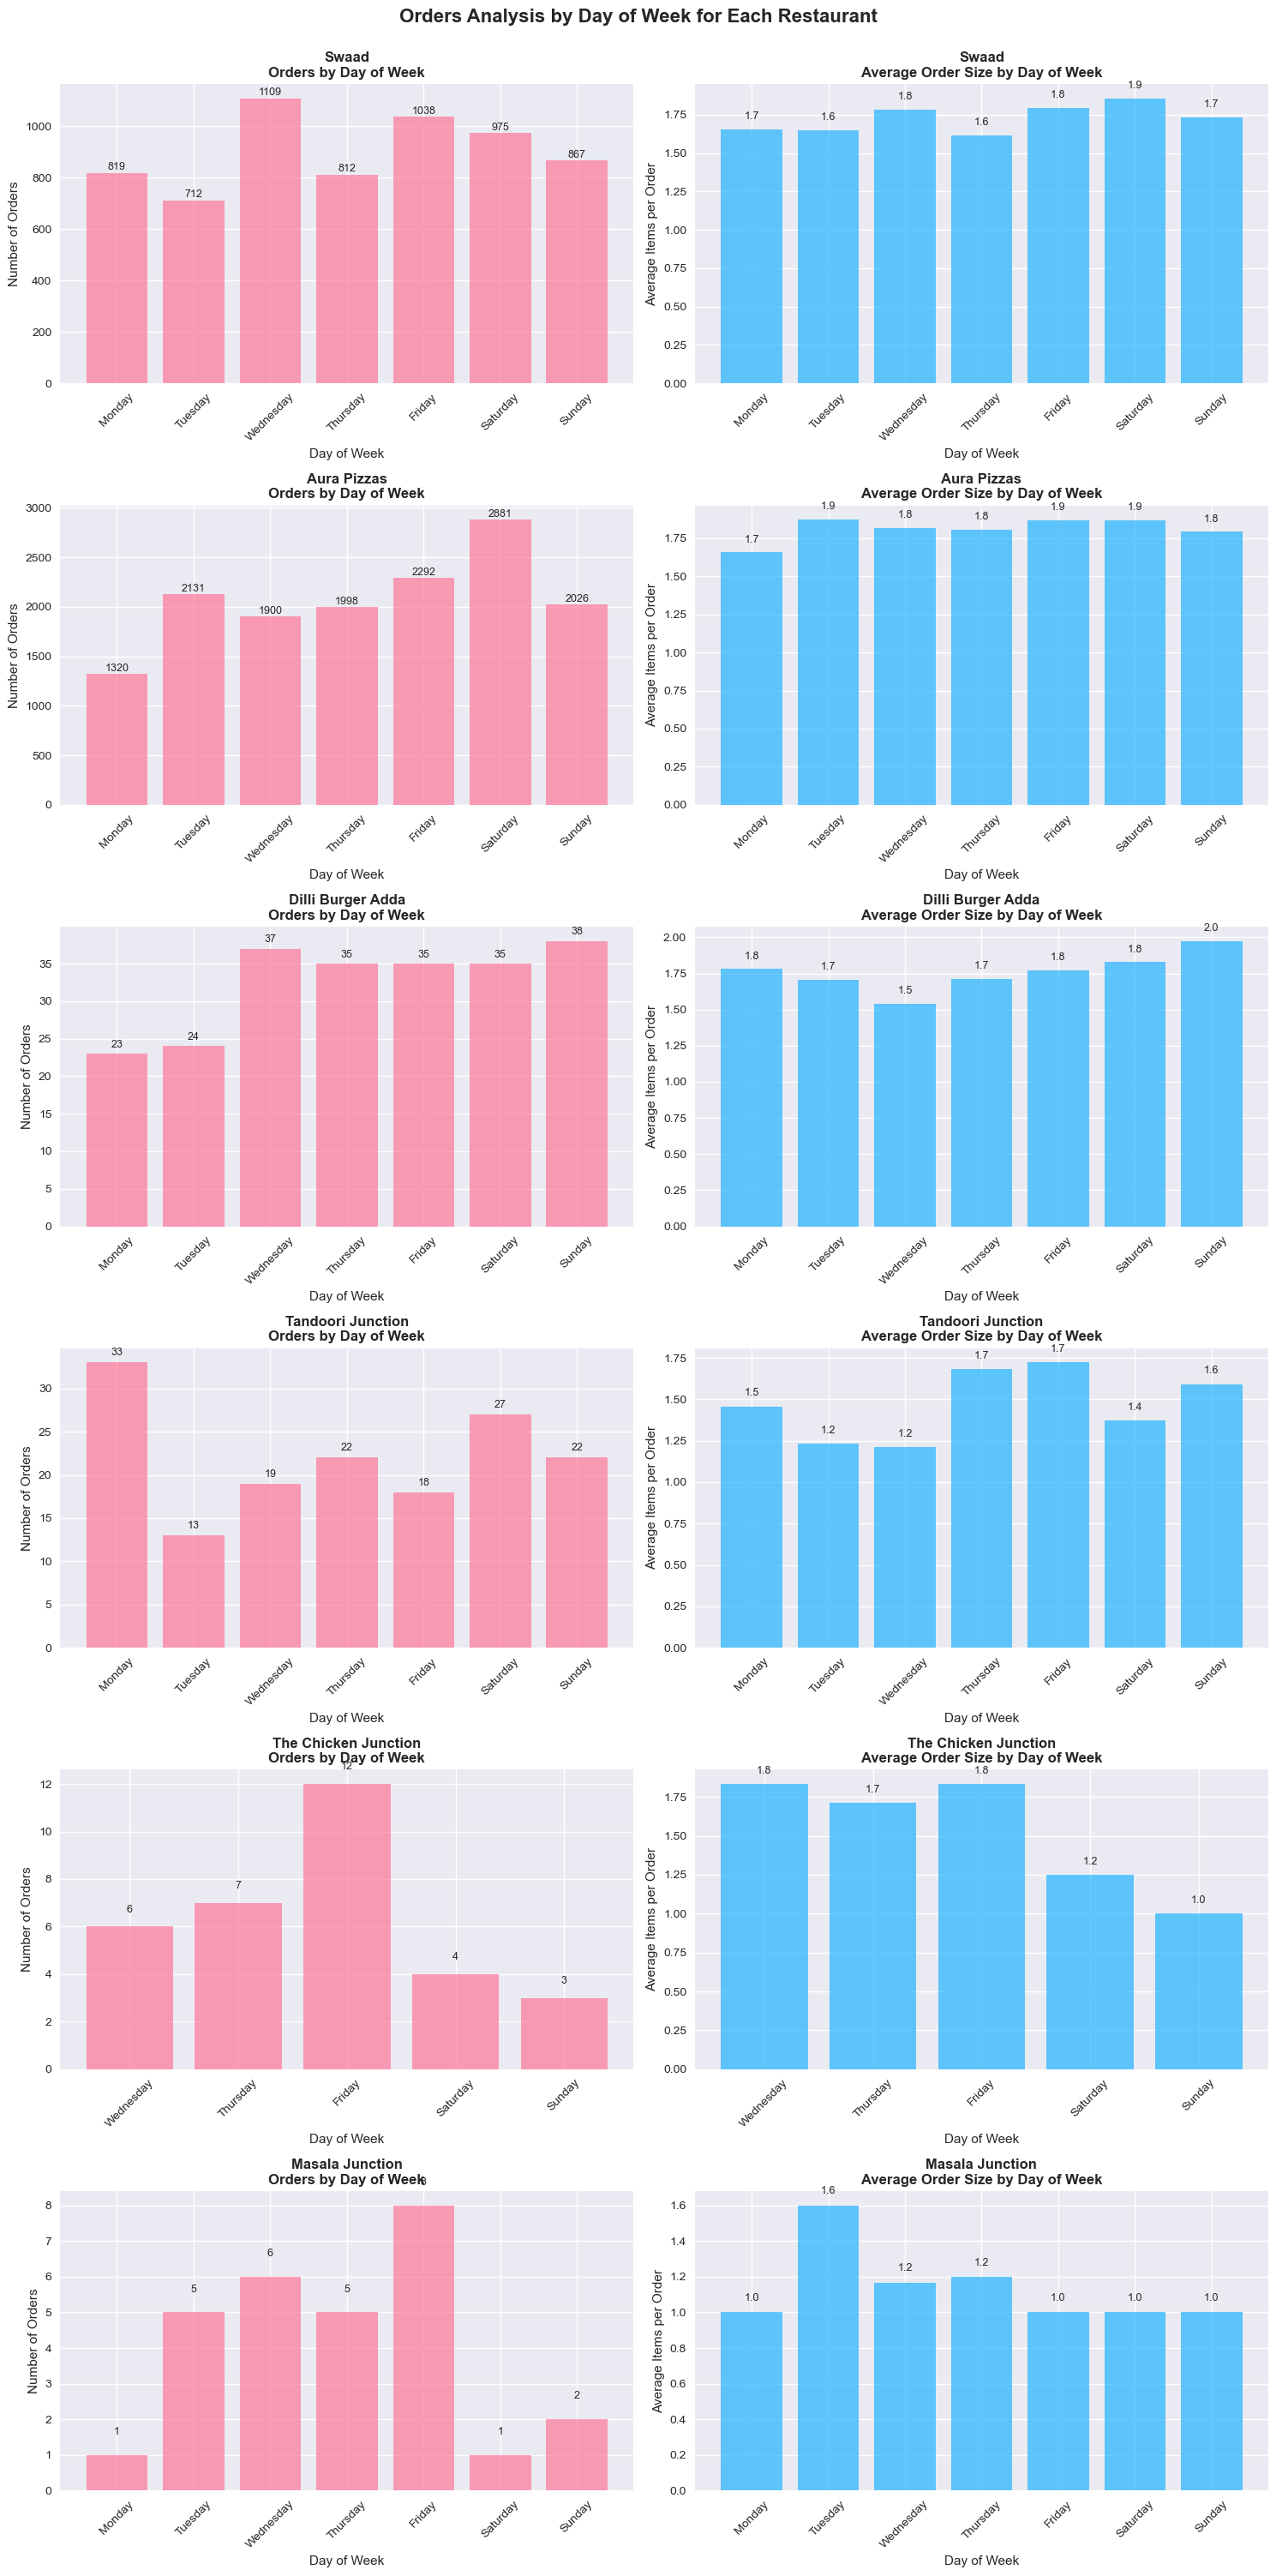

In [19]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    day_order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    fig, axes=plt.subplots(len(restaurants), 2, figsize=(15, 5*len(restaurants)))
    
    for i, restaurant in enumerate(restaurants):
        restaurant_data=data[data['Restaurant name']==restaurant]
        
        day_counts=restaurant_data['Day'].value_counts()
        day_counts=day_counts.reindex(day_order)
        axes[i][0].bar(day_counts.index, day_counts.values, color='#ff7799', alpha=0.7)
        axes[i][0].set_xlabel('Day of Week')
        axes[i][0].set_ylabel('Number of Orders')
        axes[i][0].set_title(f'{restaurant}\nOrders by Day of Week', fontweight='bold')
        axes[i][0].tick_params(axis='x', rotation=45)
        
        for j, count in enumerate(day_counts.values):
            if not pd.isna(count):
                axes[i][0].text(j, count+0.5, str(int(count)), ha='center', va='bottom', fontsize=9)
        avg_items_by_day=restaurant_data.groupby('Day')['Items count'].mean().reindex(day_order)
        
        axes[i][1].bar(avg_items_by_day.index, avg_items_by_day.values, color='#22b3ff', alpha=0.7)
        axes[i][1].set_xlabel('Day of Week')
        axes[i][1].set_ylabel('Average Items per Order')
        axes[i][1].set_title(f'{restaurant}\nAverage Order Size by Day of Week', fontweight='bold')
        axes[i][1].tick_params(axis='x', rotation=45)
        
        for j, avg in enumerate(avg_items_by_day.values):
            if not pd.isna(avg):
                axes[i][1].text(j, avg+0.05, f'{avg:.1f}', ha='center', va='bottom', fontsize=9)
    
    plt.suptitle('Orders Analysis by Day of Week for Each Restaurant', fontsize=16, fontweight='bold', y=1)
    plt.tight_layout()
    plt.show()

The charts display the number of orders and the average order size (items per order) across the days of the week for each restaurant.

**Number of Orders**

High-volume restaurants (Aura Pizzas and Swaad) show a clear increase in orders toward the weekend with Saturday and Sunday being the busiest days.
Tandoori Junction follows a similar but smaller weekend pattern. Low-volume restaurants (The Chicken Junction, Masala Junction) show irregular patterns due to limited data.

**Average Order Size**

In most restaurants, the average number of items per order is slightly higher during the weekend, indicating larger or shared orders.
Weekdays show relatively stable values, generally between 1.2 and 1.7 items per order.
Small-volume restaurants exhibit more fluctuation because of low sample sizes.

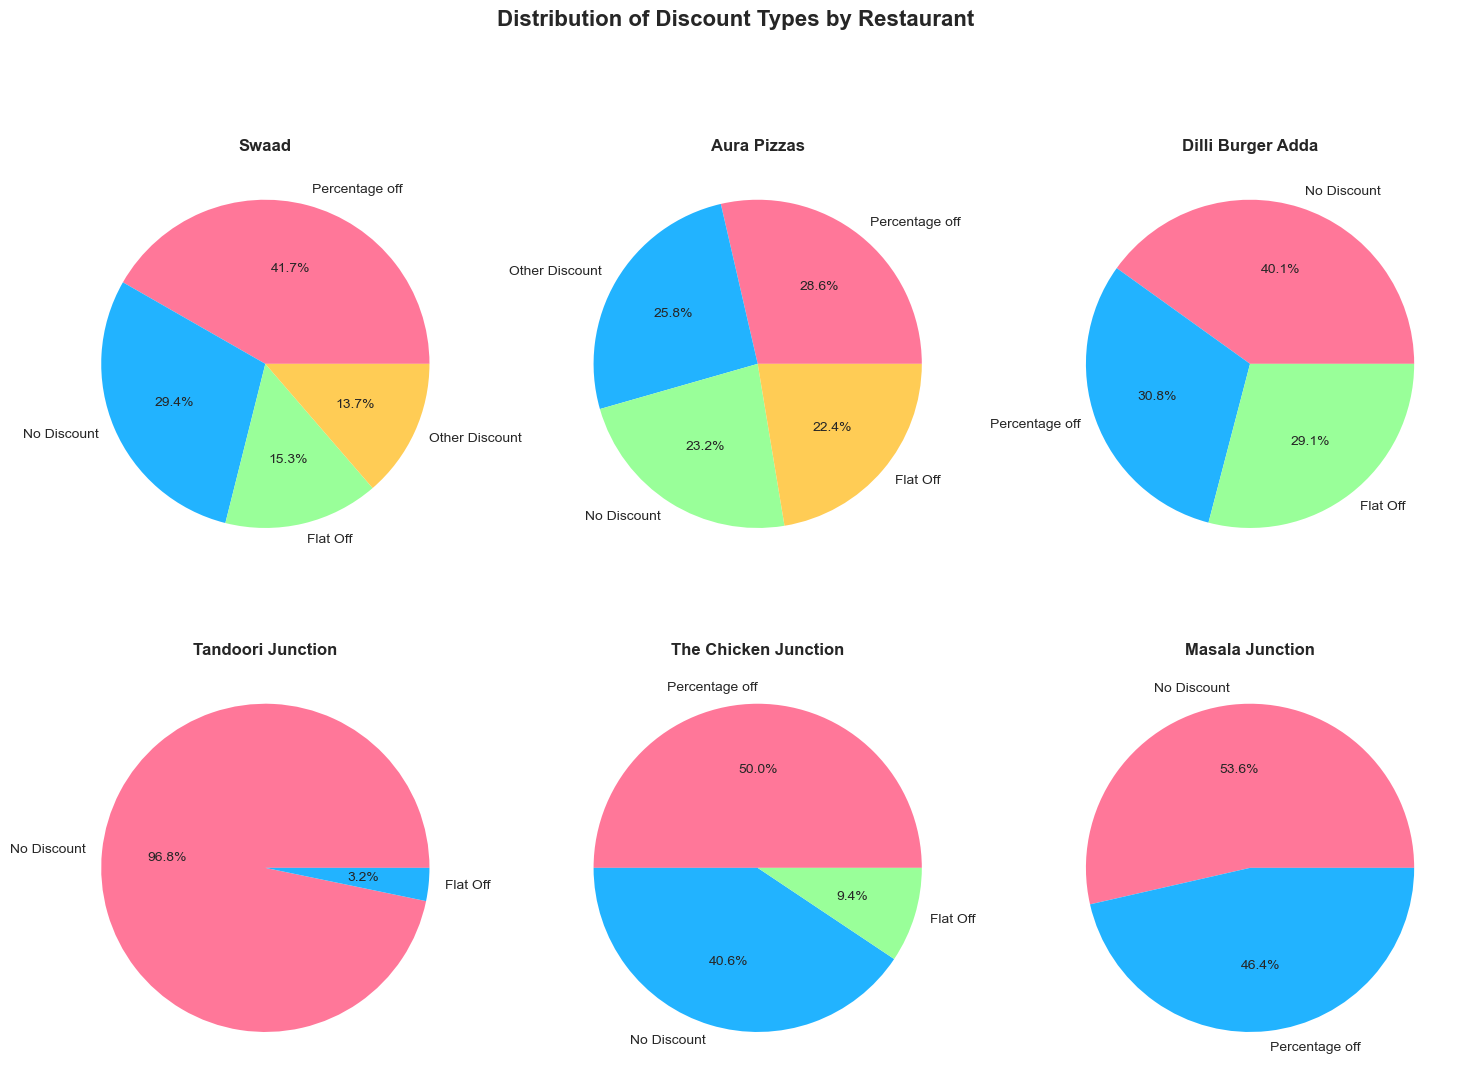

In [20]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18,12))
    axes=axes.flatten()

    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            discount_count=restaurant_data['Discount Type'].value_counts()
            color_map=dict(zip(discount_count, colors))
            axes[i].pie(discount_count.values, labels=discount_count.index, autopct='%1.1f%%', colors=colors)
            axes[i].set_title(f'{restaurant}', fontweight='bold')
    plt.suptitle('Distribution of Discount Types by Restaurant', fontsize=16, fontweight='bold', y=1)
    plt.show()
    

The charts illustrate the structure of discounts applied across different restaurants.

Clear differences in promotional strategy can be observed:

Tandoori Junction applies almost no discounts (97% of orders without any promotion).

Swaad, Aura Pizzas and Dilli Burger Adda maintain a balanced mix of promotional types with a notable share of percentage-based and fixed-amount discounts.

The Chicken Junction and Masala Junction show a high proportion of orders without discounts (50-60%).

**Overall, discount strategies vary significantly between restaurants, indicating individualized pricing approaches shaped by location, customer profile and business positioning.**

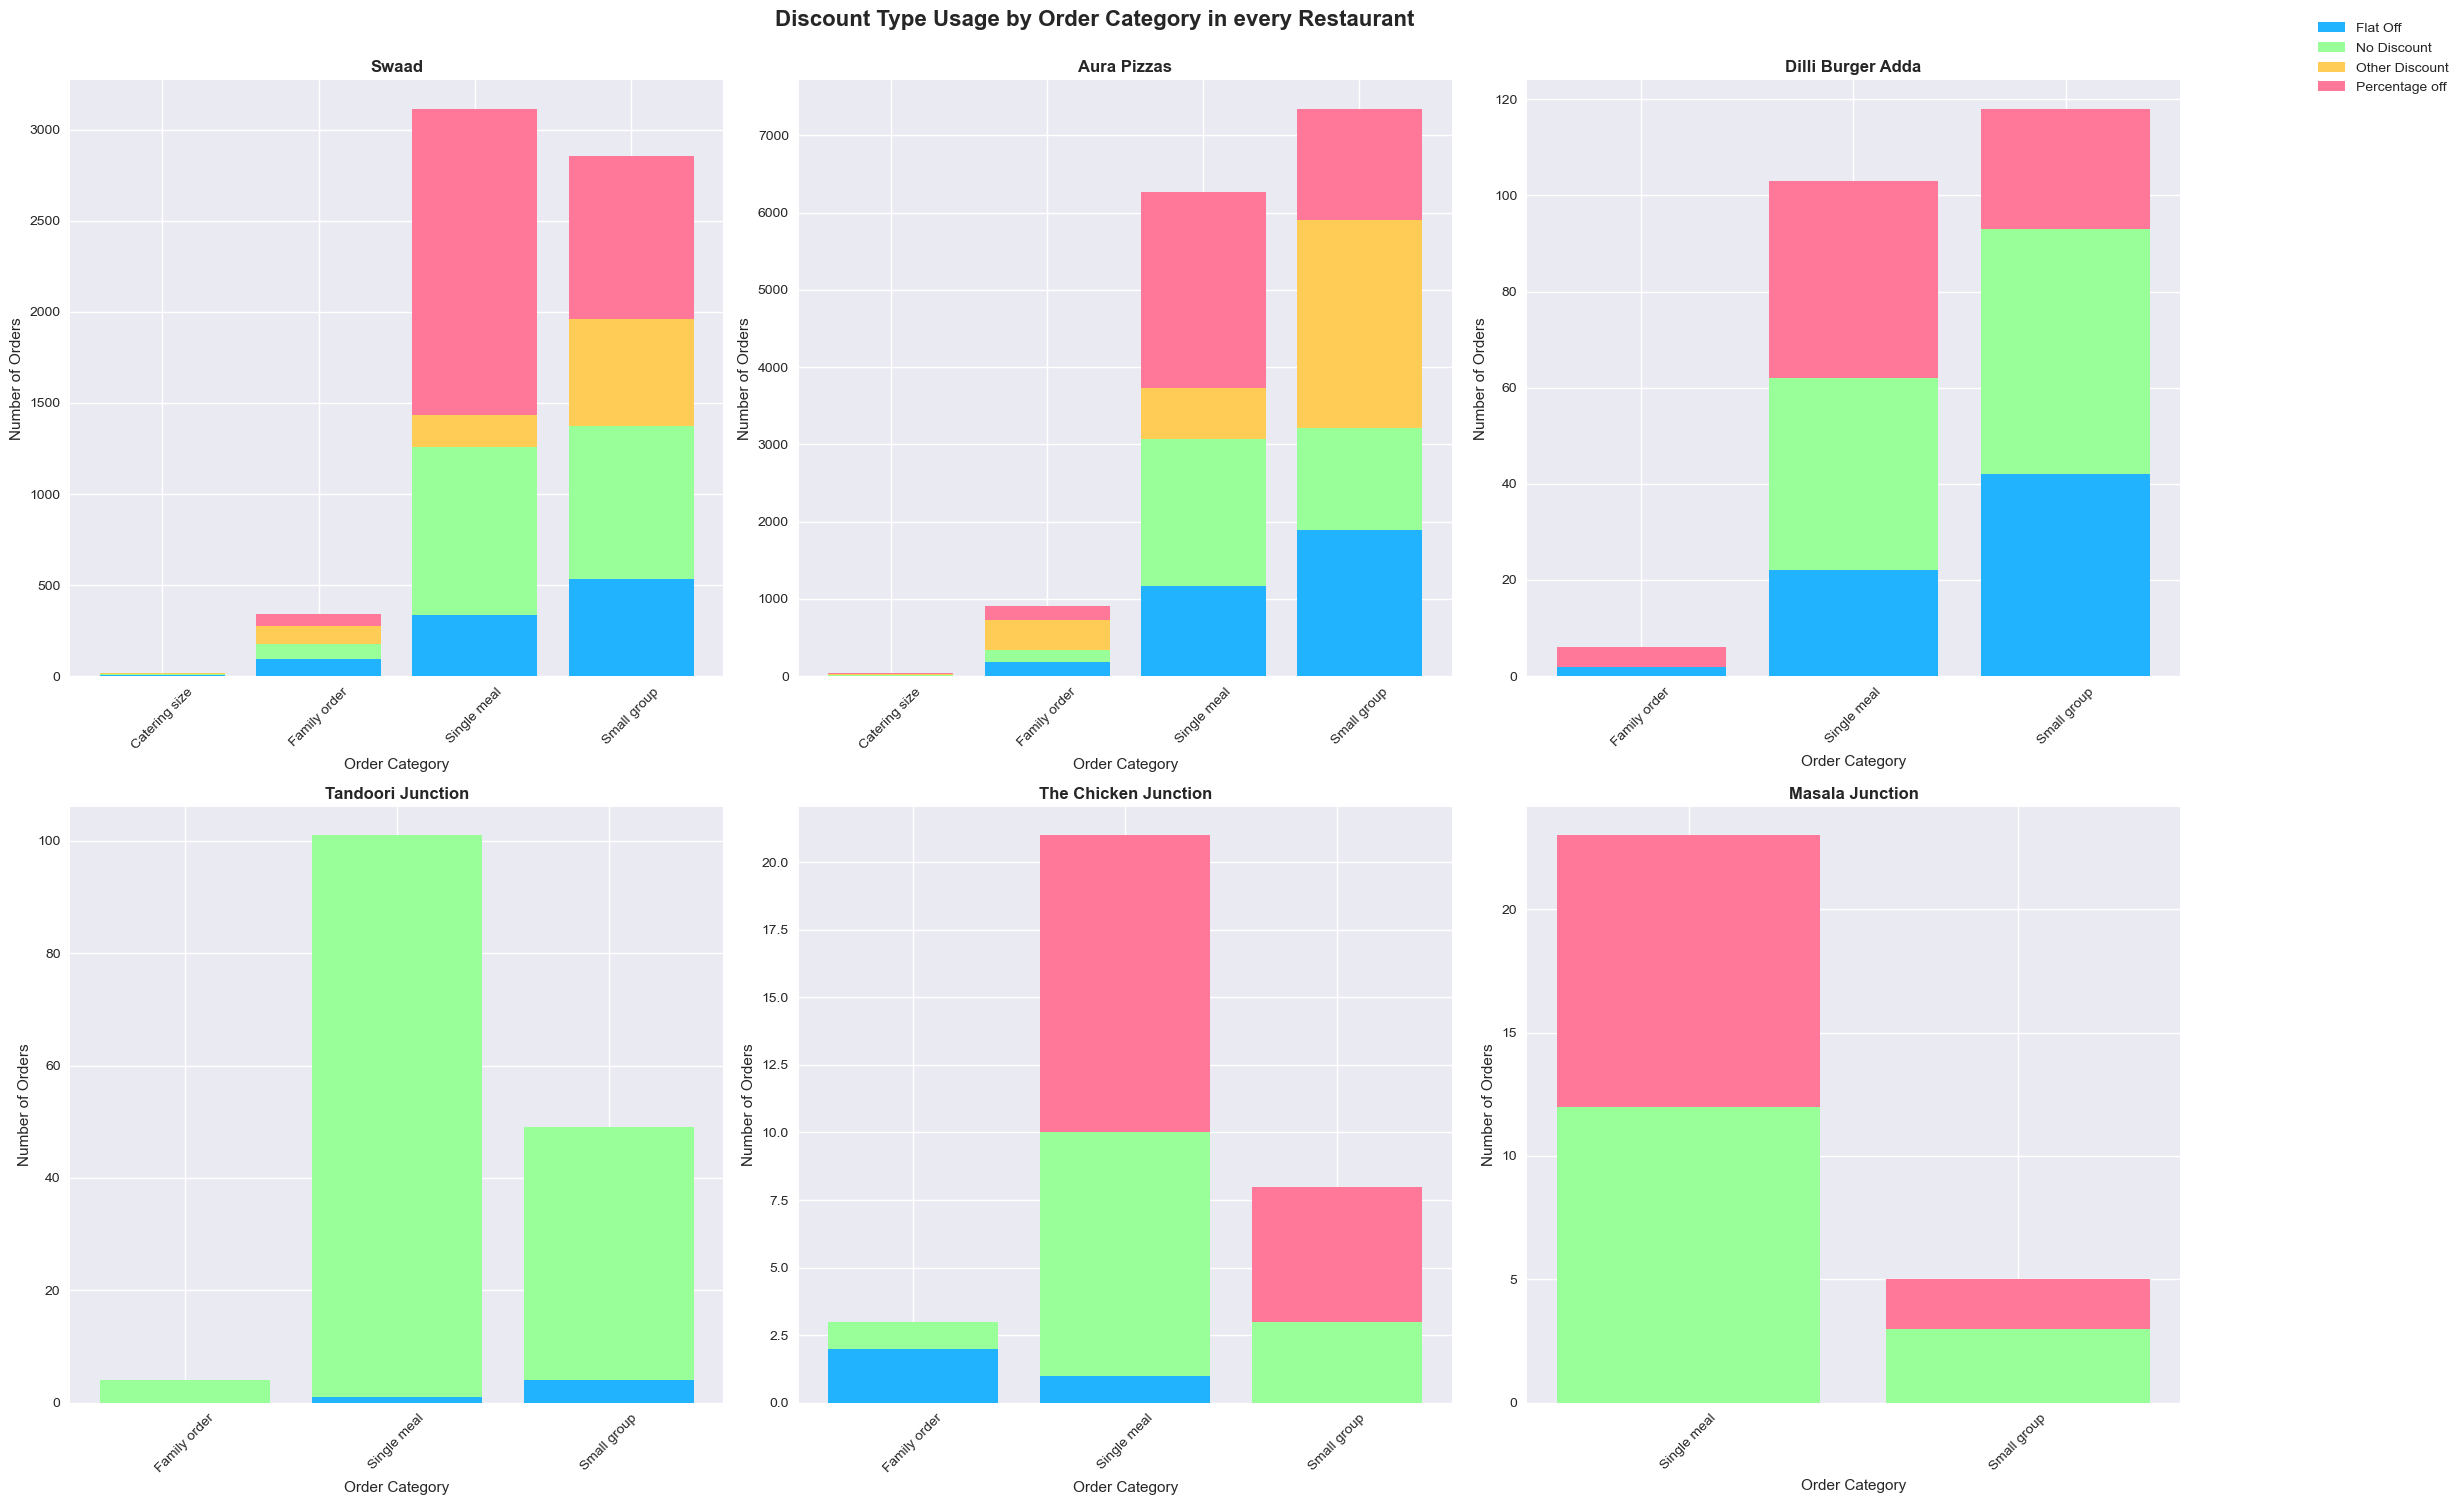

In [21]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(22, 15))
    axes=axes.flatten()

    discount_type=data['Discount Type'].unique()
    color_map=dict(zip(discount_type, colors[:len(discount_type)]))

    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            discount_by_category=pd.crosstab(restaurant_data['Items per Order Category'], restaurant_data['Discount Type'])
            bottom=None
            for discount_type in discount_by_category.columns:
                values=discount_by_category[discount_type].values
                axes[i].bar(discount_by_category.index, values, color=color_map[discount_type], label=discount_type, bottom=bottom)
                if bottom is None:
                    bottom=values
                else:
                    bottom+=values
            axes[i].set_xlabel('Order Category')
            axes[i].set_ylabel('Number of Orders')
            axes[i].set_title(f'{restaurant}', fontweight='bold')
            axes[i].tick_params(axis='x', rotation=45)
    handles, labels=axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle('Discount Type Usage by Order Category in every Restaurant', fontsize=16, fontweight='bold', y=1)
    plt.tight_layout()
    plt.show()

   

The bar charts illustrate the distribution of discount types across different order categories (Single meal, Small group, Family order, Catering size) for each restaurant.

Non-discounted orders dominate across all restaurants and order categories. There are a consistent distribution patterns, discount type proportions remain stable regardless of order size. There is no significant correlation between order size and promotion type. There are sistinct discount profiles, therefore each restaurant maintain characteristic for them discount profile.

**The discount policy appears standardized within each restaurant and is not tailored to order size, indicating a lack of differentiated promotional strategy targeting specific customer segments.**

C:\Users\pikol\AppData\Local\Temp\ipykernel_2448\2623010818.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Order Time']=pd.to_datetime(data['Order Time'])


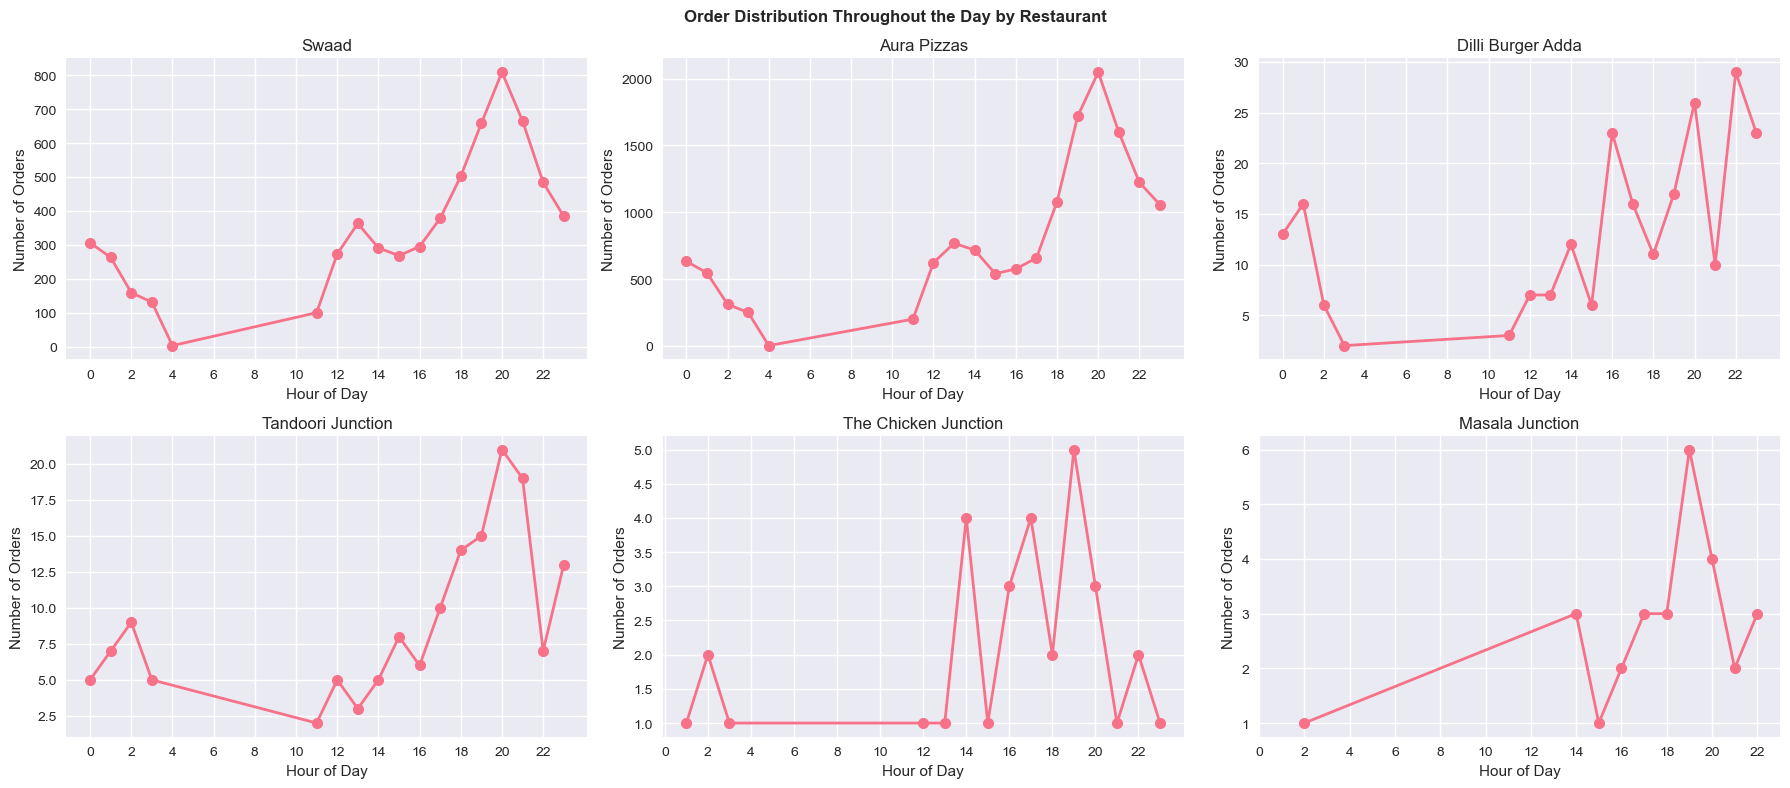

In [22]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    data['Order Time']=pd.to_datetime(data['Order Time'])
    data['Order Hour']=data['Order Time'].dt.hour
    fig, axes=plt.subplots(2, 3, figsize=(18,8))
    axes=axes.flatten()
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            hourly_orders=restaurant_data['Order Hour'].value_counts().sort_index()
            axes[i].plot(hourly_orders.index, hourly_orders.values, marker='o', linewidth=2, markersize=8)
            axes[i].set_xlabel('Hour of Day')
            axes[i].set_ylabel('Number of Orders')
            axes[i].set_xticks(range(0, 24, 2))
            axes[i].set_title(f'{restaurant}')
            
    plt.suptitle('Order Distribution Throughout the Day by Restaurant', fontweight='bold')
    plt.tight_layout()
    plt.show()

The data shows that customer demand is heavily concentrated in the evening hours with most restaurants reaching their peak order volumes between 6 PM and 9 PM. Larger restaurants such as Swaad and Aura Pizzas experience substantial surges during dinner, indicating strong consumer preference for these cuisines at night. Midday demand exists but is significantly lower, suggesting that lunch contributes far less to total daily revenue. Smaller restaurants: Dilli Burger Adda, Tandoori Junction, The Chicken Junction and Masala Junction, see moderate but consistent evening increases, reflecting a similar pattern on a smaller scale. 

**Overall, the outcome highlights dinner as the primary revenue driver across all restaurants with operational planning and marketing efforts best focused on late day demand.**

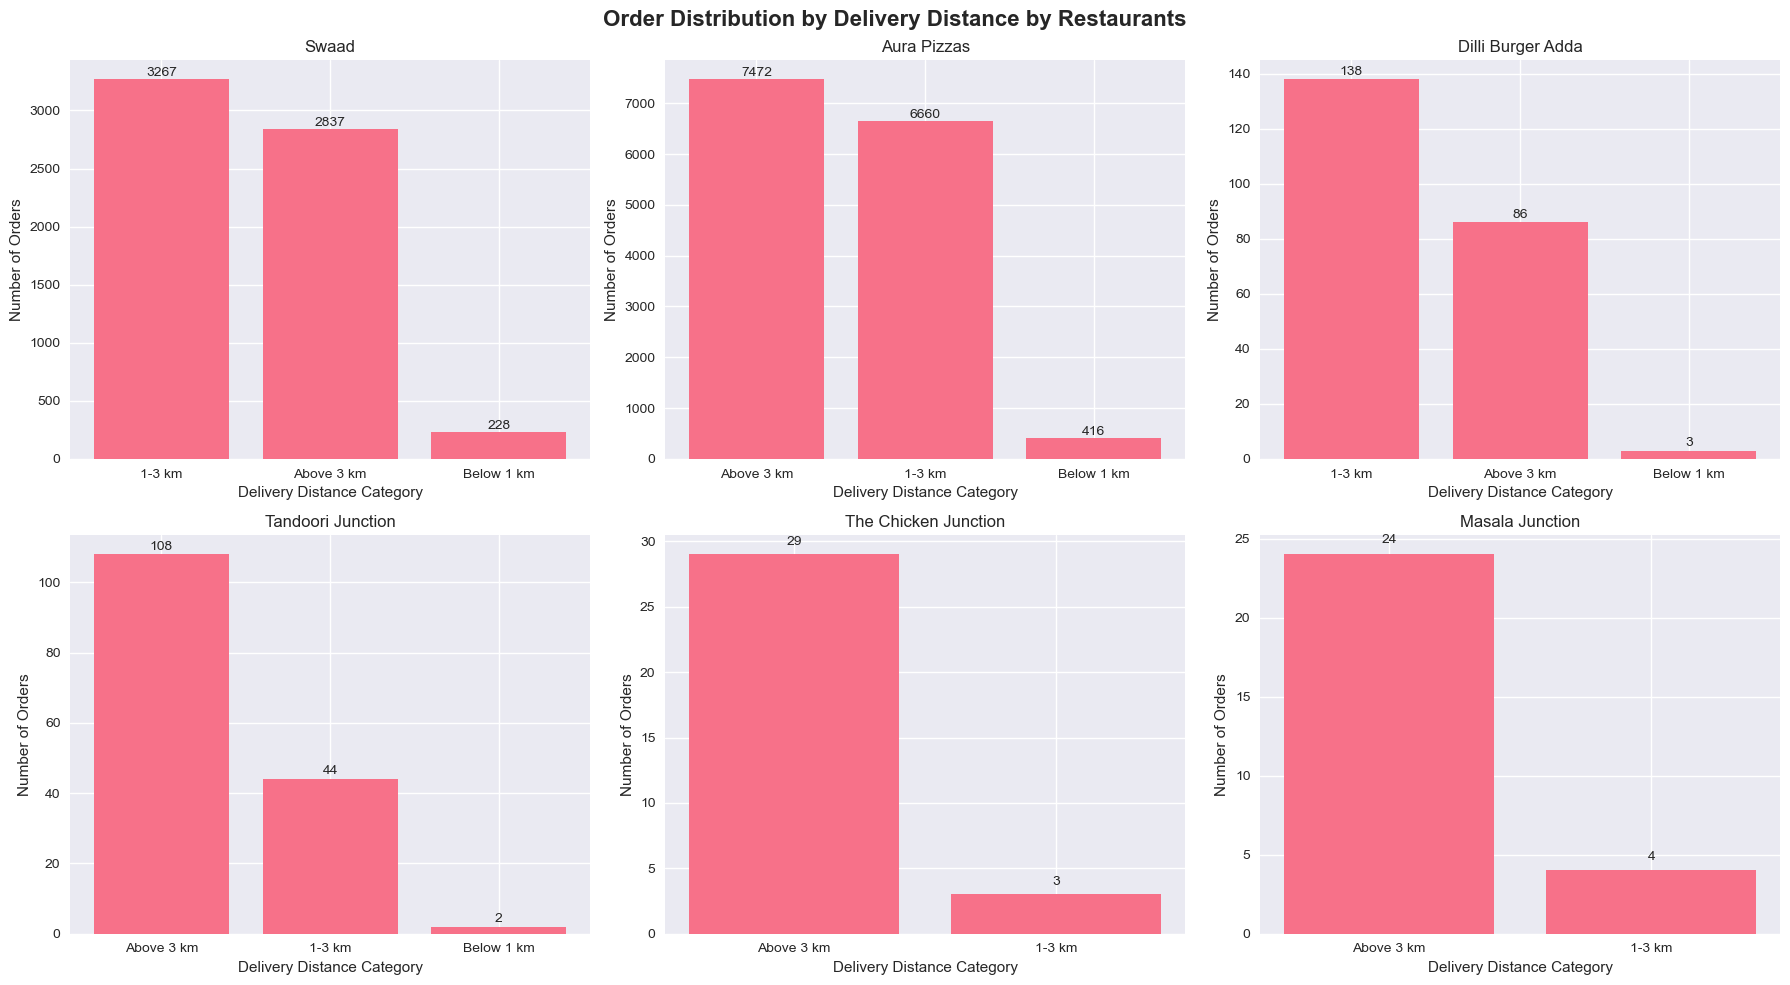

In [23]:
if 'Restaurant name' in data.columns:
    restaurants=data['Restaurant name'].unique()
    fig, axes=plt.subplots(2, 3, figsize=(18, 10))
    axes=axes.flatten()
    for i, restaurant in enumerate(restaurants):
        if i<len(axes):
            data_rest=data[data['Restaurant name']==restaurant]
            distance_count=data_rest['Delivery Distance Category'].value_counts()
            bars=axes[i].bar(distance_count.index, distance_count.values)
            axes[i].set_xlabel('Delivery Distance Category')
            axes[i].set_ylabel('Number of Orders')
            axes[i].set_title(f'{restaurant}')
            for bar in bars:
                height=bar.get_height()
                axes[i].text(bar.get_x()+bar.get_width()/2., height+0.5, f'{int(height)}', ha='center', va='bottom')
    plt.suptitle('Order Distribution by Delivery Distance by Restaurants', fontweight='bold', fontsize=16)
    plt.tight_layout()
    plt.show()


The diagrams show distribution of distance from restaurant to the fcustomer.

The analysis reveals a consistent pattern across all restaurant locations. The majority of orders originate from customers located 1-3 kilometers or further away. This demonstrates a business model heavily dependent on mid-to-long distance delivery. High-volume establishments like Aura Pizzas and Swaad show exceptional order volumes from beyond 3 kilometers. This indicates strong brand recognition and extensive geographic appeal. Smaller venues such as The Chicken Junction and Masala Junction similarly rely on distant customers. However, these smaller locations operate at significantly lower absolute volumes. Orders from within 1 kilometer radius are minimal across all locations. This suggests limited capture of nearby residential or walk-in conversion demand. The distance distribution pattern underscores that delivery operations beyond the immediate vicinity are the primary revenue driver.

**Overall, the outcome highlights that longer-distance delivery is the primary driver of order volume for this restaurant group. Optimized logistics management is critically important. Strategic delivery zone expansion is essential to maintain competitive advantage in this market.**

In [26]:
data.dtypes.value_counts()

object            17
float64           12
int64              3
datetime64[ns]     1
bool               1
int32              1
Name: count, dtype: int64

We chose the numeric columns to make a covariance and correlation matrix to better see relationships between variables.

In [52]:
avaible_numeric_col=[]
for col in data:
    if "ID" in col:
        continue
    if col in data.columns and data[col].dtype in ['float64', 'int64', 'int32']:
        avaible_numeric_col.append(col)

print('Columns in covariance matrix:', avaible_numeric_col)

Columns in covariance matrix: ['Bill subtotal', 'Packaging charges', 'Restaurant discount (Promo)', 'Restaurant discount (Flat offs, Freebies & others)', 'Gold discount', 'Brand pack discount', 'Total', 'KPT duration (minutes)', 'Rider wait time (minutes)', 'Total Discount', 'Distance_km', 'Order Preparation Time', 'Items count', 'Order Hour']


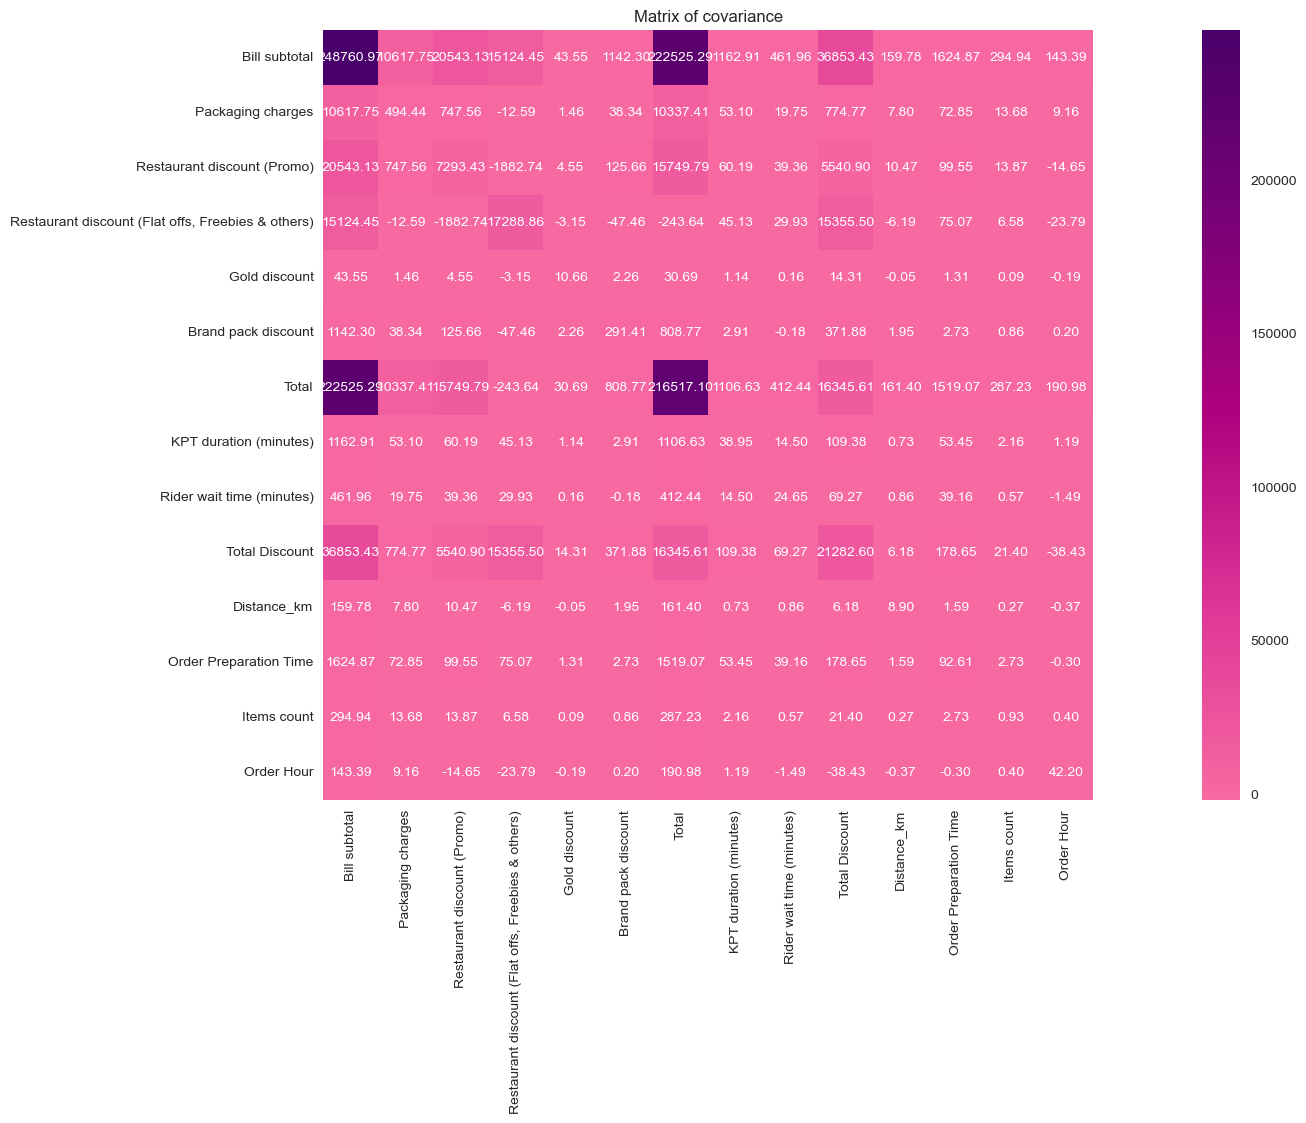

In [54]:
cov_matrix=data[avaible_numeric_col].cov()
plt.figure(figsize=(28, 10))
sns.heatmap(cov_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='RdPu',
            center=0,
            square=True,
)
plt.title('Matrix of covariance')
plt.show()

Bill Subtotal shows very high variance, indicating wide price variation across orders. It has strong positive covariance with Total Discount, suggesting higher-value orders tend to receive larger discounts. 

Items Count has minimal covariance with bill amount, indicating item count alone doesn't drive order value significantly.

Order Preparation Time shows moderate positive covariance with both KPT Duration and Rider Wait Time, as expected since it's their sum. Bill Subtotal has positive covariance with preparation time, suggesting higher-value orders take longer to prepare.

Order Hour shows weak relationships with most variables, except negative covariance with Total Discount, indicating discounts may be less common during peak hours.

Items Count has minimal impact on wait times, suggesting order complexity doesn't significantly affect preparation or rider waiting periods.

**The matrix reveals that order value and discount amounts are the most strongly related variables, while timing factors show expected operational relationships but weaker overall correlations.**

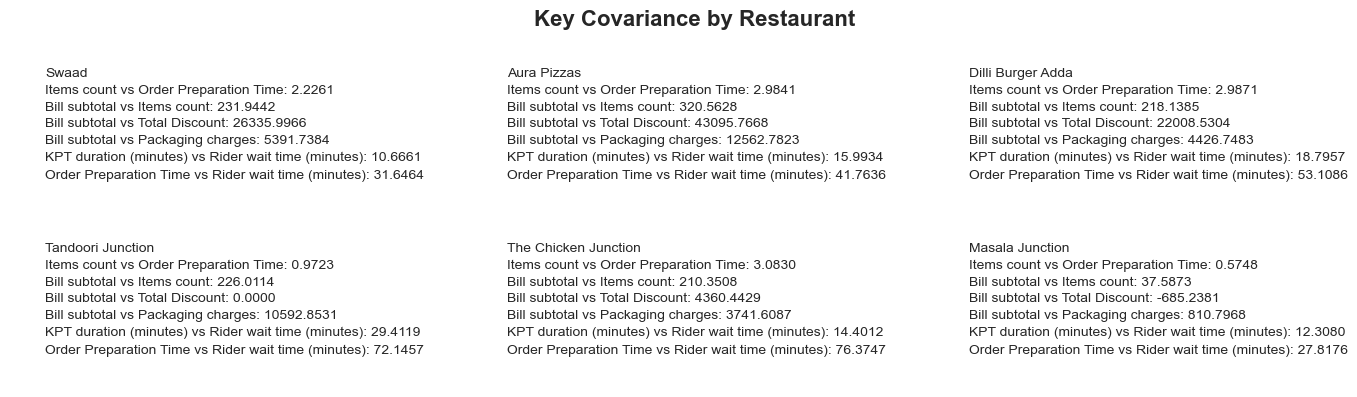

In [55]:
if 'Restaurant name' in data.columns:
    key_relationships=[
    ('Items count', 'Order Preparation Time'),
    ('Bill subtotal', 'Items count'),
    ('Bill subtotal', 'Total Discount'),
    ('Bill subtotal', 'Packaging charges'),
    ('KPT duration (minutes)', 'Rider wait time (minutes)'),
    ('Order Preparation Time', 'Rider wait time (minutes)')
    ]
    fig, axes=plt.subplots(2, 3, figsize=(14, 4))
    axes=axes.flatten()
    
    for i, restaurant in enumerate(data['Restaurant name'].unique()):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            
            covv=[]
            for var1, var2 in key_relationships:
                if var1 in restaurant_data.columns and var2 in restaurant_data.columns:
                    cov=restaurant_data[var1].cov(restaurant_data[var2])
                    covv.append(f"{var1} vs {var2}: {cov:.4f}")
            
            axes[i].axis('off')
            text_content=f"{restaurant}\n"+"\n".join(covv)
            axes[i].text(0.1, 0.9, text_content, transform=axes[i].transAxes, fontsize=10, va='top', linespacing=1.5)
    
    plt.suptitle('Key Covariance by Restaurant', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

The covariance results show how key operational metrics move together across restaurants. Overall, bill subtotal has the largest covariances with item count, discounts and packaging charges, indicating these financial components scale strongly with order value.

Order preparation time and rider wait time consistently show substantial positive covariance, confirming that longer prep times directly translate into longer rider delays.

KPT duration also covaries positively with rider wait time, though to a lesser degree than total prep time. Covariance values differ by restaurant due to differences in scale and operational variability, but the directional patterns remain consistent across all sites.

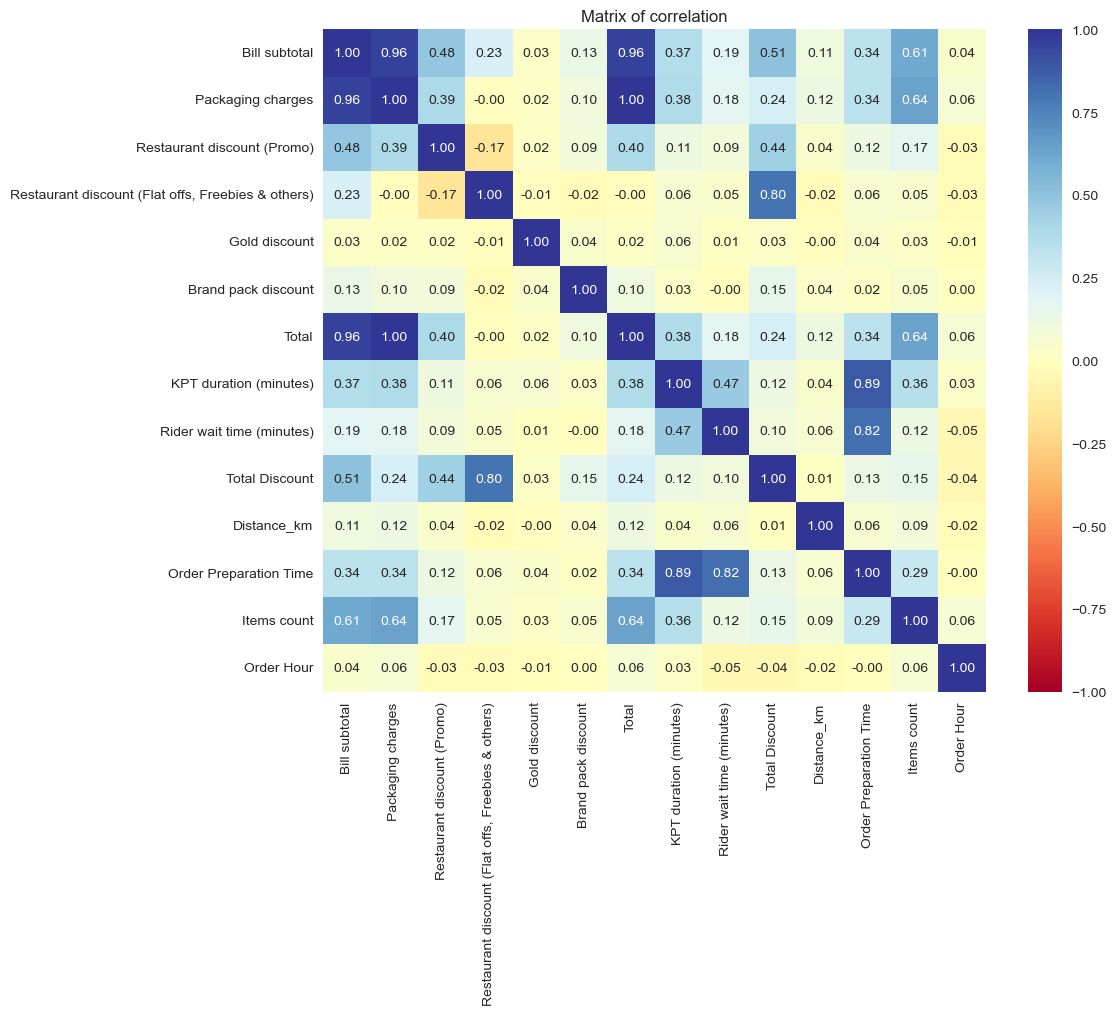

In [41]:
corr_matrix=data[avaible_numeric_col].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='RdYlBu', 
            vmin=-1, 
            vmax=1,
            center=0,
            square=True)
plt.title('Matrix of correlation')
plt.tight_layout()
plt.show()

**Key Operational Covariance Patterns**

Order preparation time shows strong positive covariance with rider wait time, indicating that longer kitchen or overall prep durations directly extend rider delays.

Bill subtotal demonstrates consistently high covariance with packaging charges and item count, reflecting how higher value orders scale proportionally in components and complexity.

**Financial Structure Observations**

Subtotal and total discounts exhibit large covariances, especially where flat or value based discounts are used, signaling discount amounts rise predictably with order value.

Packaging fees scale sharply with bill value, suggesting standardized cost structures across restaurants.

**Limited Influence Factors**

Item count vs preparation time shows relatively low covariance, indicating that menu complexity or batching processes mitigate item-level impact on prep duration.

Kitchen processing time contributes to rider wait time though with less magnitude than overall prep time.

**The covariance patterns highlight stable and predictable operational relationships, especially around order-value and time based metrics. At the same time, weaker covariances in item-level preparation and certain discount interactions point to opportunities to refine workflow efficiency and optimize pricing or discount segmentation.**

C:\Users\pikol\anaconda33\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\pikol\anaconda33\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


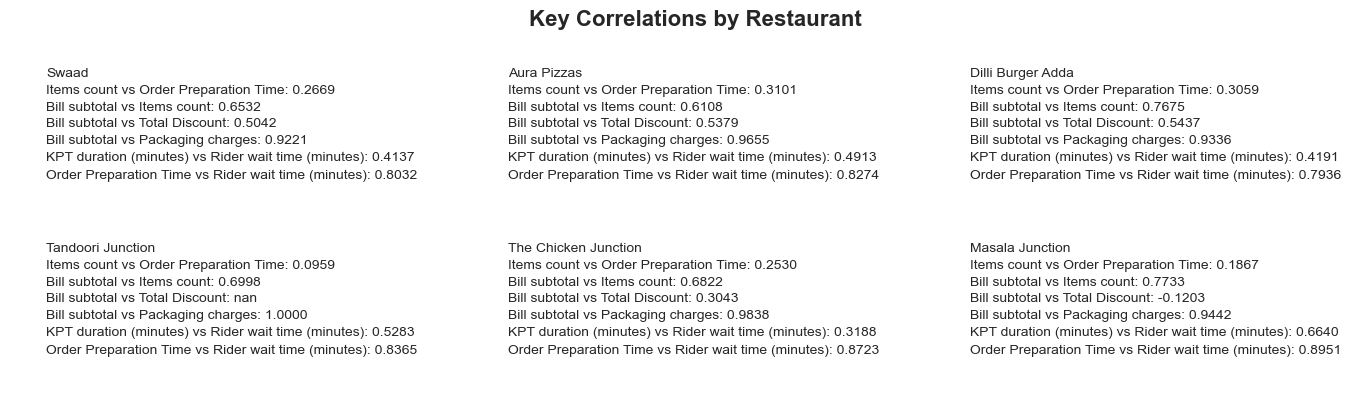

In [56]:
if 'Restaurant name' in data.columns:
    key_relationships=[
        ('Items count', 'Order Preparation Time'),
        ('Bill subtotal', 'Items count'), 
        ('Bill subtotal', 'Total Discount'),
        ('Bill subtotal', 'Packaging charges'),
        ('KPT duration (minutes)', 'Rider wait time (minutes)'),
        ('Order Preparation Time', 'Rider wait time (minutes)')
    ]
    fig, axes=plt.subplots(2, 3, figsize=(14, 4))
    axes=axes.flatten()
    
    for i, restaurant in enumerate(data['Restaurant name'].unique()):
        if i<len(axes):
            restaurant_data=data[data['Restaurant name']==restaurant]
            
            correlations=[]
            for var1, var2 in key_relationships:
                if var1 in restaurant_data.columns and var2 in restaurant_data.columns:
                    corr=restaurant_data[var1].corr(restaurant_data[var2])
                    correlations.append(f"{var1} vs {var2}: {corr:.4f}")
            
            axes[i].axis('off')
            text_content=f"{restaurant}\n"+"\n".join(correlations)
            axes[i].text(0.1, 0.9, text_content, transform=axes[i].transAxes, fontsize=10, va='top', linespacing=1.5)
    
    plt.suptitle('Key Correlations by Restaurant', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

**Strongest Patterns**

Bill subtotal and packaging charges show very high positive correlations (around 0.92-1.00).
That means higher value orders consistently have higher packaging fees.

Order preparation time and rider wait time also show strong positive correlations (often 0.79-0.89).
Longer prep directly leads to riders waiting longer.

**Moderate Patterns**

Bill subtotal and item count have moderately strong correlations (0.65-0.77).
Bigger orders usually include more items.

**Weaker or Variable Patterns**

Items count vs order preparation time varies more (0.09-0.31).
More items do not always mean much longer preparation times.

KPT duration (kitchen processing time) vs rider wait time is mid range (~0.31-0.66).
Kitchen processing contributes to rider wait time but not as strongly as total prep time.

**Across all restaurants, the biggest operational bottleneck appears to be that longer preparation times heavily increase rider wait times and order value consistently drives packaging charges. Other relationships vary but are generally positive.**

In [92]:
print("========== FINAL ANALYSIS SUMMARY OF FULL SET ==========\n")

print(f"Total number of orders analyzed: {len(data):}")
print(f"Number of unique dishes identified: {len(popular_dishes_data)}")
print(f"Most popular dish overall: '{popular_dishes_data.iloc[0]['Dish']}' "f"({popular_dishes_data.iloc[0]['Frequency']} orders)")
print(f"\nAverage preparation time across all restaurants: "f"{data['Order Preparation Time'].mean():.1f} minutes")

correct_rate=data['Is Order Ready Correctly'].mean()*100
print(f"Percentage of correctly prepared orders: {correct_rate:.2f}%")

most_popular_day=data['Day'].value_counts().idxmax()
print(f"Most active day of the week: {most_popular_day}")

avg_items=data['Items count'].mean()
print(f"Average number of items per order: {avg_items:.2f}")

most_common_category=data['Items per Order Category'].value_counts().idxmax()
print(f"Most common order size category: {most_common_category}")

busiest_time=data['Order Time'].value_counts().idxmax()
print(f"Busiest recorded ordering time: {busiest_time}")

avg_discount=data['Total Discount'].mean()
print(f"Average discount amount applied: {avg_discount:.2f}")

print("\n========== KEY BUSINESS INSIGHTS ==========\n")

print("1. Dinner hours (18:00–21:00) dominate order volume across all restaurants.\n"
      "   Restaurants should prioritize staffing and food prep efficiency during this window.\n")

print("2. Small-group orders (2–3 items) are the most common order type, suggesting\n"
      "   that customers often buy for 2 people rather than large families or single diners.\n")

print("3. Longer preparation times strongly increase rider wait time.\n"
      "   Kitchens that reduce processing variability will improve delivery speed.\n")

print("4. High-value orders reliably generate higher discount usage and higher packaging fees.\n"
      "   This indicates predictable pricing behavior tied to order size.\n")

print("5. Large restaurants like Swaad and Aura Pizzas show the most stable trends,\n"
      "   while low-volume restaurants produce noisy patterns due to small sample sizes.\n")

print("6. Delivery demand mainly comes from 1–3 km and 3km+ zones.\n"
      "   Local walk-in or hyperlocal delivery is minimal, so delivery optimization is critical.\n")

print("7. Order accuracy is high (around 90%), but slight improvements in peak periods may reduce errors.\n")


========== FINAL ANALYSIS SUMMARY OF FULL SET ==========

Total number of orders analyzed: 21321
Number of unique dishes identified: 13
Most popular dish overall: 'ooh saucy fries' (11 orders)

Average preparation time across all restaurants: 22.1 minutes
Percentage of correctly prepared orders: 89.52%
Most active day of the week: Saturday
Average number of items per order: 1.79
Most common order size category: Small group
Busiest recorded ordering time: 2025-11-20 20:20:00
Average discount amount applied: 100.03

========== KEY BUSINESS INSIGHTS ==========

1. Dinner hours (18:00–21:00) dominate order volume across all restaurants.
   Restaurants should prioritize staffing and food prep efficiency during this window.

2. Small-group orders (2–3 items) are the most common order type, suggesting
   that customers often buy for 2 people rather than large families or single diners.

3. Longer preparation times strongly increase rider wait time.
   Kitchens that reduce processing variabili